# Breast Cancer Classification Across Two Mammography Datasets

## Authors

Maximilian Dieringer (h12314676)                      
Harald Körbel (h12208935)

## Project Overview

This notebook analyzes how two deep learning models for breast cancer classification perform when applied across two different mammography datasets.
We investigate two central aspects:

- Domain shift: how a model trained on the RSNA dataset behaves when evaluated on KAU                                     
- Catastrophic forgetting: how performance on RSNA changes after fine tuning on KAU

Our goal is to compare two widely used convolutional neural network architectures and understand their robustness across datasets.

## Motivation for the Project

Our motivation for this project is deeply personal. Having witnessed cases of breast cancer within our immediate surroundings, we wanted to engage with this topic on a deeper level and explore how effectively machine learning models can assist in detecting breast cancer from medical images. This project was not only an opportunity to work on a problem that directly affects and interests us, but also a chance to contribute to something with potential real-world impact.

Additionally, the idea of working with image-based input data was particularly compelling for us. The combination of personal relevance, scientific curiosity, and the challenge of applying deep learning techniques to medical imaging made this project especially meaningful.

## Base Model

**EfficientNet-B0 Breast Cancer Classification (Hugging Face)**                                    
https://huggingface.co/keanteng/efficientnet-b0-breast-cancer-classification-0604-2

Key characteristics:
- EfficientNet-B0 architecture  
- Pretrained on ImageNet  
- Fine tuned on the Mini-DDBS-JPEG mammography dataset  
- Input size: 256×256  
- Binary labels: Has_Cancer (1) vs Normal (0)

**ResNet-50 (Torchvision)**                                
https://huggingface.co/microsoft/resnet-50

Key characteristics:
- ResNet-50 architecture with residual connections
- Pretrained on ImageNet
- Widely used as a strong and stable baseline for medical imaging
- Default input size 224×224 (we upscale to 256×256 for consistency)
- Binary classification head adapted for Cancer vs No Cancer prediction

## Datasets

- **Dataset 1: RSNA Screening Mammography**  
    Used for: baseline inference, fine tuning, evaluation  
    https://www.kaggle.com/datasets/theoviel/rsna-breast-cancer-256-pngs

- **Dataset 2: KAU-BCMD Mammography**  
    Used for: zero-shot inference, fine tuning, evaluation  
    https://www.kaggle.com/datasets/orvile/kau-bcmd-mamography-dataset

Both datasets allow creating a consistent binary cancer label.

## Notebook Workflow Overview

This notebook is structured into four main parts:

- **Part 1: Shared Setup and Data Pipeline**  
  Data loading, preprocessing, splitting, transforms, dataloaders, and all shared utilities used by both models.

- **Part 2: EfficientNet-B0 Pipeline**  
  Full training workflow for EfficientNet-B0, including baseline, fine-tuning on RSNA and KAU, and back-evaluation.

- **Part 3: ResNet-50 Pipeline**  
  Identical workflow applied to ResNet-50 to enable a controlled architecture comparison.

- **Part 4: Final Cross-Model Comparison**  
  Finally we compare the Models from Part 2 & 3

------------------------------------
# Part 1: Shared Setup and Data Pipeline

## 1. Setup

1.1 Import libraries  
1.2 Configure global settings and file paths  
1.3 Define hyperparameters  


## 2. Data Preparation

2.1 RSNA: load and clean metadata  
2.2 RSNA: split and save stratified CSV files  
2.3 KAU: load and clean metadata  
2.4 KAU: split and save stratified CSV files  


## 3. Shared Utilities

3.1 Dataset class for CSV-based image loading  
3.2 Image transforms (train, validation, test)  
3.3 Helper functions for metrics  
3.4 Training and evaluation functions  
3.5 Function to load EfficientNet-B0 model  
3.6 Function to load ResNet-50 model  


## 1. Setup

### 1.1 Import libraries

We import all core libraries used throughout the project:

- **pathlib / json**: file paths and config handling  
- **pandas**: handling CSV files  
- **torch / torchvision**: deep learning framework and image handling  
- **sklearn**: train/val/test splitting and metrics  
- **PIL**: image loading  
- **huggingface_hub**: downloading pretrained models
- **matplotlib**: plotting graphs  

This ensures that all later notebook sections have the required dependencies ready.

In [1]:
# 1.1 Import libraries

from pathlib import Path
import json

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils import shuffle

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from torchvision import models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from PIL import Image
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file as safe_load

import matplotlib.pyplot as plt

# Select device: use GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


### 1.2 Configure global settings and file paths

We define:

- root directories for RSNA images and metadata (train.csv)  
- dedicated output directories for saving train/val/test CSV splits for **RSNA** and **KAU**  
- global constants such as test/validation split fractions and the random seed  
- backwards-compatible aliases (`IMAGES_DIR`, `LABELS_CSV_PATH`, `OUTPUT_DIR`) so existing code keeps working

This creates a consistent file structure so all remaining stages can load data reliably.


In [2]:
# 1.2 Configure global settings and file paths

# RSNA image directory (Theo Viel 256×256 PNGs)
RSNA_IMAGES_DIR = Path("/kaggle/input/rsna-breast-cancer-256-pngs")

# RSNA labels (original competition train.csv)
RSNA_LABELS_CSV_PATH = Path("/kaggle/input/rsna-breast-cancer-detection/train.csv")

# Where we will store the train/val/test CSV splits for RSNA
RSNA_SPLITS_DIR = Path("/kaggle/working/rsna_splits")
RSNA_SPLITS_DIR.mkdir(parents=True, exist_ok=True)

# Where we will store the train/val/test CSV splits for KAU
KAU_SPLITS_DIR = Path("/kaggle/working/kau_splits")
KAU_SPLITS_DIR.mkdir(parents=True, exist_ok=True)

# Fractions for splitting the data
TEST_FRACTION = 0.25                 # 25% of all data for test
VAL_FRACTION_WITHIN_TRAINVAL = 0.20  # 20% of the remaining 75% → 15% of total as validation
RANDOM_STATE = 42                    # for reproducible splits

print("RSNA_IMAGES_DIR:", RSNA_IMAGES_DIR)
print("RSNA_LABELS_CSV_PATH:", RSNA_LABELS_CSV_PATH)
print("RSNA_SPLITS_DIR:", RSNA_SPLITS_DIR)
print("KAU_SPLITS_DIR:", KAU_SPLITS_DIR)
print("TEST_FRACTION:", TEST_FRACTION)
print("VAL_FRACTION_WITHIN_TRAINVAL:", VAL_FRACTION_WITHIN_TRAINVAL)
print("RANDOM_STATE:", RANDOM_STATE)

# Backwards compatible aliases so existing code below keeps working
IMAGES_DIR      = RSNA_IMAGES_DIR
LABELS_CSV_PATH = RSNA_LABELS_CSV_PATH
OUTPUT_DIR      = RSNA_SPLITS_DIR

RSNA_IMAGES_DIR: /kaggle/input/rsna-breast-cancer-256-pngs
RSNA_LABELS_CSV_PATH: /kaggle/input/rsna-breast-cancer-detection/train.csv
RSNA_SPLITS_DIR: /kaggle/working/rsna_splits
KAU_SPLITS_DIR: /kaggle/working/kau_splits
TEST_FRACTION: 0.25
VAL_FRACTION_WITHIN_TRAINVAL: 0.2
RANDOM_STATE: 42


### 1.3 Define hyperparameters

We set the training hyperparameters that will be used across all fine-tuning stages:

- batch size  
- number of DataLoader workers  
- learning rate and weight decay  
- number of epochs for RSNA (Model 1)  
- number of epochs for KAU (Model 2)

These parameters ensure that all fine-tuned variants of the base models are trained with consistent settings across stages.

In [3]:
# 1.3 Define hyperparameters

# Shared across all training stages
BATCH_SIZE  = 16          # number of images per batch
NUM_WORKERS = 2           # number of worker processes for data loading

LEARNING_RATE = 3e-5      # learning rate for AdamW optimizer
WEIGHT_DECAY  = 5e-4      # L2 regularization to reduce overfitting

# Number of training epochs per stage
NUM_EPOCHS_RSNA = 30      # epochs for fine tuning on RSNA (Model 1)
NUM_EPOCHS_KAU  = 10      # epochs for fine tuning on KAU (Model 2)

print("BATCH_SIZE:", BATCH_SIZE)
print("NUM_WORKERS:", NUM_WORKERS)
print("LEARNING_RATE:", LEARNING_RATE)
print("WEIGHT_DECAY:", WEIGHT_DECAY)
print("NUM_EPOCHS_RSNA:", NUM_EPOCHS_RSNA)
print("NUM_EPOCHS_KAU:", NUM_EPOCHS_KAU)

BATCH_SIZE: 16
NUM_WORKERS: 2
LEARNING_RATE: 3e-05
WEIGHT_DECAY: 0.0005
NUM_EPOCHS_RSNA: 30
NUM_EPOCHS_KAU: 10


## 2. Data Preparation

### 2.1 RSNA: load and clean metadata

We load the original RSNA metadata (train.csv) and perform:

- column selection (patient_id, image_id, cancer)  
- removal of duplicates  
- construction of PNG filenames  
- creation of absolute image paths  
- filtering for existing image files  
- adding a dataset identifier column (`dataset_source = "RSNA"`)  
- a quick sanity check of the class distribution after filtering  

This results in a clean DataFrame where each row corresponds to one real RSNA image.


In [4]:
# 2.1 RSNA: load and clean metadata

# Load original RSNA train.csv with labels
rsna_labels = pd.read_csv(RSNA_LABELS_CSV_PATH)
print("RSNA train.csv loaded, number of rows:", len(rsna_labels))
display(rsna_labels.head())

# Keep only the columns we actually need and remove duplicate rows
rsna_labels = rsna_labels[["patient_id", "image_id", "cancer"]].drop_duplicates(
    subset=["patient_id", "image_id"]
)
print("\nAfter selecting columns and dropping duplicates:")
display(rsna_labels.head())
print("Number of unique image entries:", len(rsna_labels))

# Helper function: build the PNG file name for each row
def make_rsna_filename(row):
    """Create the PNG filename for a given RSNA row."""
    return f"{row['patient_id']}_{row['image_id']}.png"

# Add filename column
rsna_labels["filename"] = rsna_labels.apply(make_rsna_filename, axis=1)

# Add full path column (Theo Viel PNG dataset)
rsna_labels["path"] = rsna_labels["filename"].apply(
    lambda name: RSNA_IMAGES_DIR / name
)

# Keep only rows where the PNG file actually exists on disk
rsna_labels["exists"] = rsna_labels["path"].apply(lambda p: p.exists())
rsna_df = (
    rsna_labels[rsna_labels["exists"]]
    .drop(columns=["exists"])
    .reset_index(drop=True)
)

# Add a dataset identifier so we can later distinguish RSNA and KAU
rsna_df["dataset_source"] = "RSNA"

print("\nDataFrame after filtering for existing PNG files:")
display(rsna_df.head())
print("Number of images with existing PNG files:", len(rsna_df))

# Quick sanity check of the class distribution after filtering
print("\nClass distribution in RSNA after filtering existing files:")
print(rsna_df["cancer"].value_counts())
print(rsna_df["cancer"].value_counts(normalize=True))

RSNA train.csv loaded, number of rows: 54706


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True



After selecting columns and dropping duplicates:


,patient_id,image_id,cancer
0,10006,462822612,0
1,10006,1459541791,0
2,10006,1864590858,0
3,10006,1874946579,0
4,10011,220375232,0


Number of unique image entries: 54706

DataFrame after filtering for existing PNG files:


,patient_id,image_id,cancer,filename,path,dataset_source
0,10006,462822612,0,10006_462822612.png,/kaggle/input/rsna-breast-cancer-256-pngs/1000...,RSNA
1,10006,1459541791,0,10006_1459541791.png,/kaggle/input/rsna-breast-cancer-256-pngs/1000...,RSNA
2,10006,1864590858,0,10006_1864590858.png,/kaggle/input/rsna-breast-cancer-256-pngs/1000...,RSNA
3,10006,1874946579,0,10006_1874946579.png,/kaggle/input/rsna-breast-cancer-256-pngs/1000...,RSNA
4,10011,220375232,0,10011_220375232.png,/kaggle/input/rsna-breast-cancer-256-pngs/1001...,RSNA


Number of images with existing PNG files: 54706

Class distribution in RSNA after filtering existing files:
cancer
0    53548
1     1158
Name: count, dtype: int64
cancer
0    0.978832
1    0.021168
Name: proportion, dtype: float64


### 2.2 RSNA: create and save stratified CSV files

We now use the full RSNA dataset without any manual class balancing.  
To obtain robust splits while preserving the original class ratio, we:

- inspect the overall class distribution and ensure that both classes are present  
- create a stratified split into train+val and test using `TEST_FRACTION`  
- further split train+val into train and validation using a stratified split  
- print class distributions (absolute and relative) for all three splits  
- save the resulting train/val/test CSV files (patient_id, image_id, cancer, path, dataset_source) to `RSNA_SPLITS_DIR`  

These CSVs serve as the unified RSNA dataset splits for all subsequent stages.


In [5]:
# 2.2 RSNA: split and save stratified CSV files

# We now use the full RSNA dataset without manual balancing.
# We only create stratified train / validation / test splits
# so that each split reflects the original class distribution.

rsna_for_split = rsna_df.copy()

# Basic sanity check: we need at least two classes to stratify
class_counts = rsna_for_split["cancer"].value_counts()
print("Class distribution in RSNA before splitting:")
print(class_counts)
print(class_counts / class_counts.sum())

if class_counts.shape[0] < 2:
    raise ValueError("RSNA dataset must contain both positive and negative examples for stratified splits.")

print("\nTotal number of RSNA images used for splits:", len(rsna_for_split))

# 1) Split into train+val and test
trainval_df, test_df = train_test_split(
    rsna_for_split,
    test_size=TEST_FRACTION,          # e.g. 0.25 of all data for test
    stratify=rsna_for_split["cancer"],
    random_state=RANDOM_STATE,
)

print("\nSizes after first split (train+val vs. test):")
print("train+val:", len(trainval_df))
print("test:     ", len(test_df))

# 2) Split train+val into train and val
train_df, val_df = train_test_split(
    trainval_df,
    test_size=VAL_FRACTION_WITHIN_TRAINVAL,   # e.g. 0.20 of train+val becomes validation
    stratify=trainval_df["cancer"],
    random_state=RANDOM_STATE,
)

print("\nFinal split sizes:")
print("train:", len(train_df))
print("val:  ", len(val_df))
print("test: ", len(test_df))

print("\nClass distribution in each split (absolute counts):")
print("Train:\n", train_df["cancer"].value_counts())
print("\nVal:\n",   val_df["cancer"].value_counts())
print("\nTest:\n",  test_df["cancer"].value_counts())

print("\nClass distribution in each split (relative frequencies):")
print("Train:\n", train_df["cancer"].value_counts(normalize=True))
print("\nVal:\n",   val_df["cancer"].value_counts(normalize=True))
print("\nTest:\n",  test_df["cancer"].value_counts(normalize=True))

# Ensure the output directory exists
RSNA_SPLITS_DIR.mkdir(parents=True, exist_ok=True)

# Save splits as CSV (same columns as before so later code keeps working)
cols_to_keep = ["patient_id", "image_id", "cancer", "path", "dataset_source"]

for name, split_df in [("train", train_df), ("val", val_df), ("test", test_df)]:
    out_path = RSNA_SPLITS_DIR / f"{name}_split.csv"
    split_df[cols_to_keep].to_csv(out_path, index=False)
    print(f"\n{name.upper()} split stored under: {out_path}")

print("\nRSNA train/val/test splits with real class ratio are now ready.")

Class distribution in RSNA before splitting:
cancer
0    53548
1     1158
Name: count, dtype: int64
cancer
0    0.978832
1    0.021168
Name: count, dtype: float64

Total number of RSNA images used for splits: 54706

Sizes after first split (train+val vs. test):
train+val: 41029
test:      13677

Final split sizes:
train: 32823
val:   8206
test:  13677

Class distribution in each split (absolute counts):
Train:
 cancer
0    32129
1      694
Name: count, dtype: int64

Val:
 cancer
0    8032
1     174
Name: count, dtype: int64

Test:
 cancer
0    13387
1      290
Name: count, dtype: int64

Class distribution in each split (relative frequencies):
Train:
 cancer
0    0.978856
1    0.021144
Name: proportion, dtype: float64

Val:
 cancer
0    0.978796
1    0.021204
Name: proportion, dtype: float64

Test:
 cancer
0    0.978797
1    0.021203
Name: proportion, dtype: float64

TRAIN split stored under: /kaggle/working/rsna_splits/train_split.csv

VAL split stored under: /kaggle/working/rsna_split

### 2.3 KAU: load and clean metadata

We traverse the KAU dataset folder structure and automatically detect the folder that contains the BI-RADS subfolders. Then we:

- read images from the BI-RADS folders `birads1`, `birads3`, `birads4`, `birads5`  
- convert BI-RADS categories into binary cancer labels (1 → no cancer, 3/4/5 → cancer)  
- store image IDs, full image paths, BI-RADS values, binary cancer labels, and a dataset identifier (`dataset_source = "KAU"`) in a DataFrame  
- report the BI-RADS and cancer label distributions as a sanity check  

This creates a consistent structure similar to the RSNA DataFrame (path + labels + dataset source).


In [6]:
# 2.3 KAU: load and clean metadata

# Root directory of the KAU BCMD dataset in the Kaggle environment
KAU_ROOT_DIR = Path("/kaggle/input/kau-bcmd-mamography-dataset")

print("KAU root directory:", KAU_ROOT_DIR)
print("Contents of KAU root directory:")
for p in KAU_ROOT_DIR.iterdir():
    print("  ", p.name)

# In the Kaggle dataset the images are inside a folder that contains
# subfolders like 'birads1', 'birads3', 'birads4', 'birads5'.
# We search for the folder that actually contains these BI-RADS folders.
potential_roots = [KAU_ROOT_DIR] + [p for p in KAU_ROOT_DIR.iterdir() if p.is_dir()]

dataset_root = None
for candidate in potential_roots:
    birads1_dir = candidate / "birads1"
    if birads1_dir.exists() and birads1_dir.is_dir():
        dataset_root = candidate
        break

if dataset_root is None:
    raise FileNotFoundError(
        "Could not find a folder containing 'birads1' inside "
        f"{KAU_ROOT_DIR}. Please check the dataset structure in Kaggle."
    )

print("\nDetected KAU dataset root:", dataset_root)

# Mapping from folder names to BI-RADS value
folder_to_birads = {
    "birads1": 1,  # negative
    "birads3": 3,  # probably benign
    "birads4": 4,  # suspicious malignant
    "birads5": 5,  # malignant
}

def birads_to_cancer(birads_value: int) -> int:
    """
    Map a BI-RADS category to a binary cancer label.

    BI-RADS 1 is treated as no cancer (0).
    BI-RADS 3, 4 and 5 are treated as cancer (1).
    """
    if birads_value in [1]:
        return 0
    elif birads_value in [3, 4, 5]:
        return 1
    else:
        raise ValueError(f"Unexpected BI-RADS value: {birads_value}")

# Collect image records from all BI-RADS folders
records = []

# We accept common image file extensions
image_extensions = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

for folder_name, birads_value in folder_to_birads.items():
    folder_path = dataset_root / folder_name

    if not folder_path.exists():
        raise FileNotFoundError(
            f"Expected BI-RADS folder '{folder_name}' not found under {dataset_root}."
        )

    # Collect all image files in this BI-RADS folder (recursively)
    image_files = [
        p
        for p in folder_path.rglob("*")
        if p.is_file() and p.suffix.lower() in image_extensions
    ]

    print(f"Found {len(image_files)} files in folder {folder_name}.")

    for img_path in image_files:
        image_id = img_path.stem
        cancer_label = birads_to_cancer(birads_value)

        records.append(
            {
                "image_id": image_id,
                "path": str(img_path),
                "birads": birads_value,
                "cancer": cancer_label,
                "dataset_source": "KAU",
            }
        )

# Build DataFrame from all collected records
kau_df = pd.DataFrame(records)

print("\nKAU DataFrame created.")
print("Shape (rows, columns):", kau_df.shape)

print("\nFirst 5 rows:")
display(kau_df.head())

print("\nBI-RADS value counts:")
print(kau_df["birads"].value_counts().sort_index())

print("\nCancer label value counts:")
print(kau_df["cancer"].value_counts().sort_index())

KAU root directory: /kaggle/input/kau-bcmd-mamography-dataset
Contents of KAU root directory:
   King Abdulaziz University Mammogram Dataset

Detected KAU dataset root: /kaggle/input/kau-bcmd-mamography-dataset/King Abdulaziz University Mammogram Dataset
Found 1865 files in folder birads1.
Found 387 files in folder birads3.
Found 102 files in folder birads4.
Found 24 files in folder birads5.

KAU DataFrame created.
Shape (rows, columns): (2378, 5)

First 5 rows:


,image_id,path,birads,cancer,dataset_source
0,2013_BC009942_ CC_R,/kaggle/input/kau-bcmd-mamography-dataset/King...,1,0,KAU
1,2013_BC011201_ MLO_R,/kaggle/input/kau-bcmd-mamography-dataset/King...,1,0,KAU
2,2018_BC0021844_ MLO_L,/kaggle/input/kau-bcmd-mamography-dataset/King...,1,0,KAU
3,2013_BC010421_ CC_R,/kaggle/input/kau-bcmd-mamography-dataset/King...,1,0,KAU
4,2013_BC011021_ CC_R,/kaggle/input/kau-bcmd-mamography-dataset/King...,1,0,KAU



BI-RADS value counts:
birads
1    1865
3     387
4     102
5      24
Name: count, dtype: int64

Cancer label value counts:
cancer
0    1865
1     513
Name: count, dtype: int64


### 2.4 KAU: split and save stratified CSV files

We now use the full KAU dataset without any manual class balancing.  
To obtain robust splits while preserving the original class ratio, we:

- inspect the overall class distribution and ensure both classes are present  
- create a stratified split into train+val and test using the same `TEST_FRACTION` as for RSNA  
- further split train+val into train and validation using a stratified split with `VAL_FRACTION_WITHIN_TRAINVAL`  
- report class distributions (absolute and relative) for all three splits  
- save the resulting train/val/test CSV files (e.g. `path`, `cancer`, `birads`, `dataset_source`) into the dedicated `KAU_SPLITS_DIR`  

These CSVs allow us to reuse the same DataLoader and training pipeline as for RSNA.


In [7]:
# 2.4 KAU: split and save stratified CSV files

# We now use the full KAU dataset without manual balancing.
# We only create stratified train / validation / test splits
# so that each split reflects the original class distribution.

kau_for_split = kau_df.copy()

# Basic sanity check: we need at least two classes to stratify
class_counts_kau = kau_for_split["cancer"].value_counts()
print("Class distribution in KAU before splitting:")
print(class_counts_kau)
print(class_counts_kau / class_counts_kau.sum())

if class_counts_kau.shape[0] < 2:
    raise ValueError("KAU dataset must contain both positive and negative examples for stratified splits.")

print("\nTotal number of KAU images used for splits:", len(kau_for_split))

# 1) Split into train+val and test
kau_trainval_df, kau_test_df = train_test_split(
    kau_for_split,
    test_size=TEST_FRACTION,           # same fraction as for RSNA
    stratify=kau_for_split["cancer"],
    random_state=RANDOM_STATE,
)

print("\nSizes after first split (train+val vs. test):")
print("train+val:", len(kau_trainval_df))
print("test:     ", len(kau_test_df))

# 2) Split train+val into train and val
kau_train_df, kau_val_df = train_test_split(
    kau_trainval_df,
    test_size=VAL_FRACTION_WITHIN_TRAINVAL,   # same relative validation size as for RSNA
    stratify=kau_trainval_df["cancer"],
    random_state=RANDOM_STATE,
)

print("\nFinal split sizes:")
print("train:", len(kau_train_df))
print("val:  ", len(kau_val_df))
print("test: ", len(kau_test_df))

print("\nClass distribution in each split (absolute counts):")
print("Train:\n", kau_train_df["cancer"].value_counts())
print("\nVal:\n",   kau_val_df["cancer"].value_counts())
print("\nTest:\n",  kau_test_df["cancer"].value_counts())

print("\nClass distribution in each split (relative frequencies):")
print("Train:\n", kau_train_df["cancer"].value_counts(normalize=True))
print("\nVal:\n",   kau_val_df["cancer"].value_counts(normalize=True))
print("\nTest:\n",  kau_test_df["cancer"].value_counts(normalize=True))

# Ensure the output directory exists
KAU_SPLITS_DIR.mkdir(parents=True, exist_ok=True)

# Save splits as CSV
# We keep the same column structure that is already present in kau_df.
# At minimum this includes "path" and "cancer"; often also "birads" and "dataset_source".
cols_to_keep = [col for col in ["path", "cancer", "birads", "dataset_source"] if col in kau_for_split.columns]

for name, split_df in [("train", kau_train_df), ("val", kau_val_df), ("test", kau_test_df)]:
    out_path = KAU_SPLITS_DIR / f"{name}_split.csv"
    split_df[cols_to_keep].to_csv(out_path, index=False)
    print(f"\n{name.upper()} split stored under: {out_path}")

print("\nKAU train/val/test splits with real class ratio are now ready.")

Class distribution in KAU before splitting:
cancer
0    1865
1     513
Name: count, dtype: int64
cancer
0    0.784272
1    0.215728
Name: count, dtype: float64

Total number of KAU images used for splits: 2378

Sizes after first split (train+val vs. test):
train+val: 1783
test:      595

Final split sizes:
train: 1426
val:   357
test:  595

Class distribution in each split (absolute counts):
Train:
 cancer
0    1118
1     308
Name: count, dtype: int64

Val:
 cancer
0    280
1     77
Name: count, dtype: int64

Test:
 cancer
0    467
1    128
Name: count, dtype: int64

Class distribution in each split (relative frequencies):
Train:
 cancer
0    0.784011
1    0.215989
Name: proportion, dtype: float64

Val:
 cancer
0    0.784314
1    0.215686
Name: proportion, dtype: float64

Test:
 cancer
0    0.784874
1    0.215126
Name: proportion, dtype: float64

TRAIN split stored under: /kaggle/working/kau_splits/train_split.csv

VAL split stored under: /kaggle/working/kau_splits/val_split.csv

TEST 

## 3. Shared utilities

### 3.1 Dataset class for CSV-based image loading

We use a single generic `CsvImageDataset` that reads image paths and labels from a CSV file.  
This dataset works for both RSNA and KAU splits, as long as the CSV contains:

- `path` – absolute or relative file path to the image  
- `cancer` – binary label where 1 means cancer and 0 means no cancer  

The dataset returns a tuple `(image_tensor, label_tensor)` where:

- `image_tensor` is an RGB image with an optional torchvision transform already applied  
- `label_tensor` is a `LongTensor` with values 0 or 1, suitable for `CrossEntropyLoss`  

This generic dataset can be used with all model pipelines (e.g. EfficientNet-B0, ResNet-50) as long as the appropriate transforms are provided.


In [8]:
# 3.1 Dataset class for CSV-based image loading

class CsvImageDataset(Dataset):
    """
    Generic dataset that reads images and binary labels from a CSV file.

    Expected columns:
      - 'path'   full file path to the image
      - 'cancer' 0 or 1
    """

    def __init__(self, csv_path, transform=None):
        # Read the CSV into a DataFrame and keep it in memory
        self.df = pd.read_csv(csv_path)

        # Optional torchvision transform pipeline applied to each image
        self.transform = transform

    def __len__(self):
        # Number of samples equals number of rows in the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row for the given index
        row = self.df.iloc[idx]

        # Extract file path and label from the row
        img_path = Path(row["path"])
        label = int(row["cancer"])

        # Load the image from disk and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if provided
        if self.transform is not None:
            image = self.transform(image)

        # CrossEntropyLoss expects labels as LongTensor with class indices
        target = torch.tensor(label, dtype=torch.long)

        return image, target

### 3.2 Image transforms (train, validation, test)

Both EfficientNet-B0 and ResNet-50 expect images of size 256×256 with ImageNet-style normalization.  
We define three transform pipelines:

- `train` with light data augmentation  
  - resize to 256×256  
  - random horizontal flip  
  - small random rotation (±10°)  
  - slight brightness/contrast jitter  
  - convert to tensor  
  - normalize with ImageNet mean and standard deviation  

- `val` deterministic preprocessing for validation  
  - resize to 256×256  
  - convert to tensor  
  - normalize with ImageNet mean and standard deviation  

- `test` identical to `val`, used for final test evaluation  

These transforms are shared across all models and datasets to keep preprocessing consistent.


In [9]:
# 3.2 Image transforms (train, validation, test)

def get_image_transforms(image_size: int = 256):
    """
    Returns torchvision transform pipelines for train, validation and test.

    All pipelines:
      - Resize to (image_size, image_size)
      - Convert to tensor
      - Normalize with ImageNet mean and std

    The train pipeline additionally applies light data augmentation
    to reduce overfitting.
    """

    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std  = [0.229, 0.224, 0.225]

    # Training transform with slightly stronger augmentation
    train_transform = T.Compose(
        [
            T.Resize((image_size, image_size)),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(degrees=10),
            T.ColorJitter(
                brightness=0.1,
                contrast=0.1,
            ),
            T.ToTensor(),
            T.Normalize(mean=imagenet_mean, std=imagenet_std),
        ]
    )

    # Validation transform without random augmentation
    val_transform = T.Compose(
        [
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=imagenet_mean, std=imagenet_std),
        ]
    )

    # For this project validation and test transforms are identical
    test_transform = val_transform

    return {
        "train": train_transform,
        "val": val_transform,
        "test": test_transform,
    }


# Create shared transforms dictionary that we will reuse later
TRANSFORMS = get_image_transforms(image_size=256)
print("Defined image transforms for train, val and test.")

Defined image transforms for train, val and test.


### 3.3 Helper functions for metrics

We use helper functions to compute and nicely print standard
binary classification metrics:

- Accuracy  
- Precision  
- Recall  
- F1 score  

All metrics treat label `1` as the positive (cancer) class.

In [10]:
# 3.3 Helper functions for metrics

def compute_metrics(y_true, y_pred):
    """
    Compute accuracy, precision, recall and F1 for binary classification.

    Parameters
    ----------
    y_true : list or 1D tensor of int
        Ground truth labels (0 or 1).
    y_pred : list or 1D tensor of int
        Predicted labels (0 or 1).

    Returns
    -------
    dict with keys: accuracy, precision, recall, f1
    """
    y_true = torch.as_tensor(y_true, dtype=torch.long).cpu().numpy()
    y_pred = torch.as_tensor(y_pred, dtype=torch.long).cpu().numpy()

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="binary",
        zero_division=0,
    )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }


def print_metrics(metrics_dict, prefix=""):
    """
    Nicely print a metrics dictionary produced by compute_metrics.
    """
    if prefix:
        print(prefix)

    print(f"Accuracy : {metrics_dict['accuracy']:.4f}")
    print(f"Precision: {metrics_dict['precision']:.4f}")
    print(f"Recall   : {metrics_dict['recall']:.4f}")
    print(f"F1 score : {metrics_dict['f1']:.4f}")

### 3.4 Training and evaluation functions

To keep all later stages simple, we define two core helpers:

- `run_one_epoch`  
  Runs one pass over a DataLoader either in training or evaluation mode and
  returns the average loss and all predictions/labels for that epoch.

- `train_model`  
  Wraps the full training loop:
  - trains for a given number of epochs  
  - evaluates on the validation set after each epoch  
  - tracks the best model based on validation recall  
  - returns the best model state dict and a history list with one log dictionary per epoch


In [11]:
# 3.4 Training and evaluation functions

def run_one_epoch(
    model,
    dataloader,
    criterion,
    optimizer=None,
    device=DEVICE,
):
    """
    Run a single epoch on the given dataloader.

    If optimizer is provided the model is trained.
    If optimizer is None the model is only evaluated.

    Returns
    -------
    avg_loss : float
    all_labels : list[int]
    all_preds  : list[int]
    """
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    running_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        # Forward pass: logits of shape (batch_size, 2)
        logits = model(images)

        loss = criterion(logits, labels)
        running_loss += loss.item() * images.size(0)

        # Convert logits to predicted class indices
        preds = torch.argmax(logits, dim=1)

        all_labels.extend(labels.detach().cpu().tolist())
        all_preds.extend(preds.detach().cpu().tolist())

        if optimizer is not None:
            loss.backward()
            optimizer.step()

    avg_loss = running_loss / len(dataloader.dataset)

    # Switch back to eval mode by default
    model.eval()
    torch.set_grad_enabled(False)

    return avg_loss, all_labels, all_preds


def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device=DEVICE,
    stage_name="training",
):
    """
    Generic training loop for binary classification.

    Tracks the best model based on validation recall and returns
    both the best state dict and a list of per epoch logs.
    """
    best_val_recall = 0.0
    best_state_dict = None
    history = []

    print(f"Start {stage_name} on device {device} for {num_epochs} epochs.")

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        # Training phase
        train_loss, train_labels, train_preds = run_one_epoch(
            model=model,
            dataloader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        train_metrics = compute_metrics(train_labels, train_preds)

        # Validation phase
        val_loss, val_labels, val_preds = run_one_epoch(
            model=model,
            dataloader=val_loader,
            criterion=criterion,
            optimizer=None,
            device=device,
        )
        val_metrics = compute_metrics(val_labels, val_preds)

        print(f"Train loss: {train_loss:.4f}")
        print_metrics(train_metrics, prefix="Train metrics:")

        print(f"\nVal loss  : {val_loss:.4f}")
        print_metrics(val_metrics, prefix="Val metrics:")

        # Store epoch log
        epoch_log = {
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_metrics": train_metrics,
            "val_metrics": val_metrics,
        }
        history.append(epoch_log)

        # Model selection based on validation recall
        val_recall = val_metrics["recall"]
        if val_recall > best_val_recall:
            best_val_recall = val_recall
            best_state_dict = model.state_dict()
            print(
                f"\nNew best validation recall: {best_val_recall:.4f}. "
                "Updated best model checkpoint in memory."
            )

    print(f"\nFinished {stage_name}. Best validation recall: {best_val_recall:.4f}")

    return best_state_dict, history

### 3.5 Function to load EfficientNet-B0 model

We create a helper that builds an EfficientNet-B0 model for
breast cancer classification and loads pretrained weights from
a Hugging Face repository (by default:

`keanteng/efficientnet-b0-breast-cancer-classification-0604-2`).

The function:

- downloads a JSON config (`config.json`) and reads `image_size` and `classes`
- creates the EfficientNet-B0 backbone without pretrained ImageNet weights
- replaces the classifier head with a linear layer matching the number of classes from the config
- loads the weights from the `model.safetensors` file
- moves the model to the given device and sets it to eval mode
- returns the model, the configured image size, and the list of class names


In [12]:
# 3.5 Function to load EfficientNet-B0 model

def load_efficientnet_b0_from_hf(
    repo_id: str = "keanteng/efficientnet-b0-breast-cancer-classification-0604-2",
    config_filename: str = "config.json",
    weights_filename: str = "model.safetensors",
    device: torch.device = DEVICE,
):
    """
    Load EfficientNet-B0 for binary breast cancer classification
    from a Hugging Face repository.

    The repository is expected to provide:
      - a JSON config with keys 'image_size' and 'classes'
      - a 'model.safetensors' file with the model weights
    """
    # Download config and read model metadata
    config_path = hf_hub_download(
        repo_id=repo_id,
        filename=config_filename,
    )

    with open(config_path, "r") as f:
        cfg = json.load(f)

    image_size = cfg.get("image_size", 256)
    class_names = cfg.get("classes", ["Has_Cancer", "Normal"])

    print("Image size from config:", image_size)
    print("Classes from config:", class_names)

    # Download the weights file
    weights_path = hf_hub_download(
        repo_id=repo_id,
        filename=weights_filename,
    )

    # Create EfficientNet-B0 architecture without pretrained weights
    model = efficientnet_b0(weights=None)

    # Replace classifier head with the correct number of output classes
    num_features = model.classifier[1].in_features
    num_classes = len(class_names)
    model.classifier[1] = nn.Linear(num_features, num_classes)

    # Load weights from safetensors file
    state_dict = safe_load(weights_path)
    missing_unexpected = model.load_state_dict(state_dict, strict=True)
    print("Loaded state dict. Missing/Unexpected keys:", missing_unexpected)

    # Move model to device and set to eval mode by default
    model.to(device)
    model.eval()

    return model, image_size, class_names


print("Utility functions for datasets, transforms, metrics and training have been defined.")

Utility functions for datasets, transforms, metrics and training have been defined.


### 3.6 Function to load ResNet50 model

We define a small helper to load a ResNet50 model pretrained on ImageNet,
adapt it for breast cancer classification, and move it to the selected device.
This keeps the rest of the training and evaluation pipeline identical to
the EfficientNet setup.

The function:

- loads a standard ImageNet-pretrained ResNet50 backbone  
- replaces the final fully connected layer with a classifier head for the desired number of classes (default: 2)  
- moves the model to the requested device and sets it to eval mode  
- returns the model, the expected image size (256) and the class names (`["Has_Cancer", "Normal"]`)


In [13]:
# 3.6 Function to load ResNet50 model

from torchvision.models import resnet50, ResNet50_Weights

def load_resnet50_base(
    num_classes: int = 2,
    device: torch.device = DEVICE,
):
    """
    Load a ResNet50 model pretrained on ImageNet and adapt it
    for binary breast cancer classification.

    This helper
    - loads the standard ImageNet pretrained ResNet50 backbone
    - replaces the final fully connected layer with a binary classifier
    - moves the model to the requested device
    - returns the model, the expected image size and the class names
    """

    # Load ResNet50 with ImageNet pretrained weights
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    # Replace final fully connected layer with a binary classifier head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Move to device and set eval mode by default
    model.to(device)
    model.eval()

    # Keep same input size as EfficientNet to reuse transforms
    image_size = 256
    class_names = ["Has_Cancer", "Normal"]

    print("ResNet50 base model loaded.")
    print("Image size:", image_size)
    print("Classes   :", class_names)

    return model, image_size, class_names

---------------------
# Part 2: EfficientNet-B0 Pipeline

## 4. Stage A: Baseline on RSNA (Eff_Base)

4.1 Load EfficientNet-B0 base model (Eff_Base)  
4.2 Build RSNA test DataLoader  
4.3 Baseline inference on RSNA test set  


## 5. Stage B: Fine Tuning on RSNA (Eff_FT1)

5.1 Build RSNA train and validation DataLoaders  
5.2 Initialize model, optimizer and class-weighted loss for RSNA  
5.3 Train EfficientNet on RSNA → Eff_FT1  
5.4 Evaluate Eff_FT1 on RSNA test set  


## 6. Stage C: Zero-Shot Evaluation on KAU (Eff_FT1)

6.1 Build KAU test DataLoader  
6.2 Evaluate Eff_FT1 on KAU test set  


## 7. Stage D: Fine Tuning on KAU (Eff_FT2)

7.1 Build KAU train and validation DataLoaders  
7.2 Initialize model, optimizer and class-weighted loss for KAU (starting from Eff_FT1)  
7.3 Train EfficientNet on KAU → Eff_FT2  
7.4 Evaluate Eff_FT2 on KAU test set  


## 8. Stage E: Back-Evaluation on RSNA (Eff_FT2)

8.1 Evaluate Eff_FT2 on RSNA test set  
8.2 Compare EfficientNet results (Eff_Base vs Eff_FT1 vs Eff_FT2)  


## 4. Stage A: Baseline on RSNA (Eff_Base)

### 4.1 Load EfficientNet-B0 base model (Eff_Base) 

We load the EfficientNet-B0 model from the Hugging Face repository:

`keanteng/efficientnet-b0-breast-cancer-classification-0604-2`

The function defined in Section 3.5:

- downloads the config & weights  
- builds the EfficientNet-B0 architecture  
- replaces the classifier for binary output  
- loads the weights  
- returns model + image size + class names  

In [14]:
# 4.1 Load EfficientNet-B0 base model (Eff_Base) 

base_model, base_image_size, base_class_names = load_efficientnet_b0_from_hf()

print("\nBase model loaded successfully.")
print("Image size:", base_image_size)
print("Classes:", base_class_names)

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Image size from config: 256
Classes from config: ['Has_Cancer', 'Normal']


model.safetensors:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Loaded state dict. Missing/Unexpected keys: <All keys matched successfully>

Base model loaded successfully.
Image size: 256
Classes: ['Has_Cancer', 'Normal']


### 4.2 Build RSNA test DataLoader

We now load the RSNA test split that we created earlier in Section 2.  
Using our shared utilities:

- `CsvImageDataset` → loads images and labels from the CSV file  
- `TRANSFORMS["test"]` → deterministic preprocessing for evaluation  
- `DataLoader` → batches the data and loads it efficiently from disk using multiple workers  

Together with the training/evaluation loop (which moves batches to the selected device), this provides the model with correctly formatted input for inference on the RSNA test set.


In [15]:
# 4.2 Build RSNA test DataLoader

RSNA_TEST_CSV = RSNA_SPLITS_DIR / "test_split.csv"

rsna_test_dataset = CsvImageDataset(
    csv_path=RSNA_TEST_CSV,
    transform=TRANSFORMS["test"],
)

rsna_test_loader = DataLoader(
    rsna_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"RSNA test dataset loaded: {len(rsna_test_dataset)} samples")

RSNA test dataset loaded: 13677 samples


### 4.3 Baseline Inference on RSNA Test Set

We evaluate the pretrained base model on the RSNA test split.

Steps:
- forward pass over the test set (no gradient computation)  
- get predicted labels  
- compute accuracy, precision, recall and F1  

This provides the baseline we will later compare against:
- Model 1 (RSNA fine-tuning)  
- Model 2 (KAU fine-tuning)  
- Cross-dataset evaluations

In [16]:
# 4.3 Baseline inference on RSNA test set

criterion = nn.CrossEntropyLoss()

# Only evaluation → optimizer=None
test_loss, y_true, y_pred = run_one_epoch(
    model=base_model,
    dataloader=rsna_test_loader,
    criterion=criterion,
    optimizer=None,
    device=DEVICE,
)

baseline_metrics = compute_metrics(y_true, y_pred)

print(f"RSNA baseline test loss: {test_loss:.4f}")
print_metrics(baseline_metrics, prefix="Baseline metrics on RSNA test set:")


RSNA baseline test loss: 230.3443
Baseline metrics on RSNA test set:
Accuracy : 0.2924
Precision: 0.0208
Recall   : 0.7034
F1 score : 0.0405


## 5. Stage B: Fine Tuning on RSNA (Eff_FT1)

### 5.1 Build RSNA train and validation DataLoaders

We now load the RSNA train and validation CSV files that we created in
Section 2.

We reuse:
- `CsvImageDataset` from Section 3.1
- `TRANSFORMS["train"]` and `TRANSFORMS["val"]` from Section 3.2

The DataLoaders take care of batching, shuffling (for train) and
background loading.

In [17]:
# 5.1 Build RSNA train and validation DataLoaders

RSNA_TRAIN_CSV = RSNA_SPLITS_DIR / "train_split.csv"
RSNA_VAL_CSV   = RSNA_SPLITS_DIR / "val_split.csv"

rsna_train_dataset = CsvImageDataset(
    csv_path=RSNA_TRAIN_CSV,
    transform=TRANSFORMS["train"],
)

rsna_val_dataset = CsvImageDataset(
    csv_path=RSNA_VAL_CSV,
    transform=TRANSFORMS["val"],
)

rsna_train_loader = DataLoader(
    rsna_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # shuffle for training
    num_workers=NUM_WORKERS,
)

rsna_val_loader = DataLoader(
    rsna_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # no shuffle for validation
    num_workers=NUM_WORKERS,
)

print(f"RSNA train samples: {len(rsna_train_dataset)}")
print(f"RSNA val samples  : {len(rsna_val_dataset)}")

RSNA train samples: 32823
RSNA val samples  : 8206


### 5.2 Initialize model, optimizer and class-weighted loss for RSNA  

For fine-tuning on RSNA we start again from the same pretrained
EfficientNet-B0 checkpoint as in Stage A.

Steps:
- load EfficientNet-B0 and weights from Hugging Face  
- compute class frequencies on the RSNA train split and derive inverse-frequency class weights  
- create a class-weighted CrossEntropy loss function using these weights  
- create an AdamW optimizer with the global learning rate and weight decay  

All layers remain trainable. We do not freeze the backbone in this project.


In [18]:
# 5.2 Initialize model, optimizer and class-weighted loss for RSNA  

# Load EfficientNet B0 from Hugging Face (same checkpoint as in Stage A)
m1_model, m1_image_size, m1_class_names = load_efficientnet_b0_from_hf()

print("\nModel for RSNA fine tuning initialized.")
print("Image size:", m1_image_size)
print("Classes   :", m1_class_names)

# Compute class weights from RSNA train split
# We access the DataFrame stored inside rsna_train_dataset (created in 5.1).
train_labels = rsna_train_dataset.df["cancer"]

class_counts = train_labels.value_counts().sort_index()
num_classes = class_counts.shape[0]
total_samples = class_counts.sum()

print("\nClass counts in RSNA train split:")
print(class_counts)

# Inverse-frequency style weights:
#   weight_c = total_samples / (num_classes * count_c)
class_weights = total_samples / (num_classes * class_counts.astype(float))

print("\nComputed class weights (before tensor conversion):")
print(class_weights)

# Convert to tensor on the correct device
class_weights_tensor = torch.tensor(
    class_weights.values,
    dtype=torch.float32,
    device=DEVICE,
)

print("\nClass weights tensor on device:")
print(class_weights_tensor)

# Define class-weighted loss function
m1_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# AdamW optimizer with global hyperparameters
m1_optimizer = torch.optim.AdamW(
    m1_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

# Optional: small sanity check on number of trainable parameters
num_trainable = sum(p.numel() for p in m1_model.parameters() if p.requires_grad)
print("Trainable parameters:", num_trainable)


Image size from config: 256
Classes from config: ['Has_Cancer', 'Normal']
Loaded state dict. Missing/Unexpected keys: <All keys matched successfully>

Model for RSNA fine tuning initialized.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']

Class counts in RSNA train split:
cancer
0    32129
1      694
Name: count, dtype: int64

Computed class weights (before tensor conversion):
cancer
0     0.510800
1    23.647695
Name: count, dtype: float64

Class weights tensor on device:
tensor([ 0.5108, 23.6477], device='cuda:0')
Trainable parameters: 4010110


### 5.3 Train EfficientNet on RSNA → Eff_FT1   

We now fine tune the model on the RSNA train split and
monitor performance on the RSNA validation split.

The helper `train_model` from Section 3.4:
- runs the training loop for `NUM_EPOCHS_RSNA`
- evaluates after each epoch on the validation set
- keeps track of the best model based on validation recall
- returns the best model weights and a training history

We then:
- load the best weights into `m1_model`
- save the best checkpoint to disk as `model1_rsna_best.pth`

In [19]:
# 5.3 Train EfficientNet on RSNA → Eff_FT1 

m1_best_state_dict, m1_history = train_model(
    model=m1_model,
    train_loader=rsna_train_loader,
    val_loader=rsna_val_loader,
    criterion=m1_criterion,
    optimizer=m1_optimizer,
    num_epochs=NUM_EPOCHS_RSNA,
    device=DEVICE,
    stage_name="Fine tuning on RSNA (Model 1)",
)

# Load best weights into the model
if m1_best_state_dict is not None:
    m1_model.load_state_dict(m1_best_state_dict)
    print("\nLoaded best validation checkpoint into m1_model.")

# Optionally save the best checkpoint to disk
MODEL1_PATH = Path("/kaggle/working/model1_rsna_best.pth")
torch.save(m1_model.state_dict(), MODEL1_PATH)
print("Saved Model 1 (RSNA fine tuned) to:", MODEL1_PATH)

Start Fine tuning on RSNA (Model 1) on device cuda for 30 epochs.

Epoch 1/30
Train loss: 0.5560
Train metrics:
Accuracy : 0.9434
Precision: 0.0245
Recall   : 0.0432
F1 score : 0.0313

Val loss  : 0.5069
Val metrics:
Accuracy : 0.9782
Precision: 0.0000
Recall   : 0.0000
F1 score : 0.0000

Epoch 2/30
Train loss: 0.5131
Train metrics:
Accuracy : 0.9760
Precision: 0.0796
Recall   : 0.0130
F1 score : 0.0223

Val loss  : 0.4942
Val metrics:
Accuracy : 0.9777
Precision: 0.1538
Recall   : 0.0115
F1 score : 0.0214

New best validation recall: 0.0115. Updated best model checkpoint in memory.

Epoch 3/30
Train loss: 0.4986
Train metrics:
Accuracy : 0.9689
Precision: 0.0925
Recall   : 0.0533
F1 score : 0.0676

Val loss  : 0.4804
Val metrics:
Accuracy : 0.9380
Precision: 0.0885
Recall   : 0.2069
F1 score : 0.1239

New best validation recall: 0.2069. Updated best model checkpoint in memory.

Epoch 4/30
Train loss: 0.4729
Train metrics:
Accuracy : 0.9529
Precision: 0.0824
Recall   : 0.1210
F1 score 

### 5.4 Evaluate Eff_FT1 on RSNA test set

Finally we evaluate Model 1 (M1) on the held out RSNA test set.

This tells us:
- how well the RSNA fine tuned model generalizes to unseen RSNA images
- how much it improves compared to the base model from Stage A

We reuse:
- `rsna_test_loader` from Section 4.2
- `run_one_epoch` and `compute_metrics` from Section 3.4 and 3.3

In [20]:
# 5.4 Evaluate Eff_FT1 on RSNA test set

m1_test_loss, m1_y_true, m1_y_pred = run_one_epoch(
    model=m1_model,
    dataloader=rsna_test_loader,
    criterion=m1_criterion,
    optimizer=None,
    device=DEVICE,
)

m1_test_metrics = compute_metrics(m1_y_true, m1_y_pred)

print(f"Model 1 RSNA test loss: {m1_test_loss:.4f}")
print_metrics(m1_test_metrics, prefix="Model 1 metrics on RSNA test set:")

# Optional quick comparison to baseline if available
if "baseline_metrics" in globals():
    print("\nQuick comparison to base model (RSNA test):")
    print(f"Baseline recall: {baseline_metrics['recall']:.4f}")
    print(f"M1 recall      : {m1_test_metrics['recall']:.4f}")

Model 1 RSNA test loss: 1.2071
Model 1 metrics on RSNA test set:
Accuracy : 0.9477
Precision: 0.0906
Recall   : 0.1621
F1 score : 0.1162

Quick comparison to base model (RSNA test):
Baseline recall: 0.7034
M1 recall      : 0.1621


## 6. Stage C: Zero-Shot Evaluation on KAU (Eff_FT1)

### 6.1 Build KAU test DataLoader

We now load the KAU test split created in Section 2.4.

We reuse:
- `CsvImageDataset` for reading images and labels from the CSV file  
- `TRANSFORMS["test"]` for deterministic preprocessing  
- the global batch size and number of workers from the setup section  

This DataLoader provides the KAU test data for zero-shot evaluation of the RSNA fine-tuned model.


In [21]:
# 6.1 Build KAU test DataLoader

KAU_TEST_CSV = KAU_SPLITS_DIR / "test_split.csv"

kau_test_dataset = CsvImageDataset(
    csv_path=KAU_TEST_CSV,
    transform=TRANSFORMS["test"],
)

kau_test_loader = DataLoader(
    kau_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"KAU test samples: {len(kau_test_dataset)}")


KAU test samples: 595


### 6.2 Evaluate Eff_FT1 on KAU test set

We now evaluate Model 1 (M1), which was fine tuned on RSNA,
on the KAU test set.

This is a **zero shot** evaluation on KAU:
- the model has never seen KAU images during training
- any performance drop compared to RSNA indicates domain shift

We reuse:
- `kau_test_loader` from step 6.1
- `run_one_epoch` and `compute_metrics` from the utilities section

In [22]:
# 6.2 Evaluate Eff_FT1 on KAU test set

m1_kau_test_loss, m1_kau_y_true, m1_kau_y_pred = run_one_epoch(
    model=m1_model,
    dataloader=kau_test_loader,
    criterion=m1_criterion,
    optimizer=None,
    device=DEVICE,
)

m1_kau_metrics = compute_metrics(m1_kau_y_true, m1_kau_y_pred)

print(f"Model 1 KAU test loss: {m1_kau_test_loss:.4f}")
print_metrics(m1_kau_metrics, prefix="Model 1 metrics on KAU test set (zero shot):")

# Optional quick comparison to RSNA test performance
if "m1_test_metrics" in globals():
    print("\nQuick comparison RSNA vs KAU for Model 1:")
    print(f"RSNA recall: {m1_test_metrics['recall']:.4f}")
    print(f"KAU recall : {m1_kau_metrics['recall']:.4f}")

Model 1 KAU test loss: 5.9872
Model 1 metrics on KAU test set (zero shot):
Accuracy : 0.7916
Precision: 0.7000
Recall   : 0.0547
F1 score : 0.1014

Quick comparison RSNA vs KAU for Model 1:
RSNA recall: 0.1621
KAU recall : 0.0547


## 7. Stage D: Fine Tuning on KAU (Eff_FT2)

### 7.1 Build KAU train and validation DataLoaders

We now load the KAU train and validation splits that we saved
in Section 2.4.

We reuse:
- `CsvImageDataset` for reading paths and labels from CSV  
- `TRANSFORMS["train"]` and `TRANSFORMS["val"]` for preprocessing  
- the global batch size and number of workers  

These DataLoaders provide the KAU data for fine-tuning the EfficientNet model (Eff_FT2).


In [23]:
# 7.1 Build KAU train and validation DataLoaders

KAU_TRAIN_CSV = KAU_SPLITS_DIR / "train_split.csv"
KAU_VAL_CSV   = KAU_SPLITS_DIR / "val_split.csv"

kau_train_dataset = CsvImageDataset(
    csv_path=KAU_TRAIN_CSV,
    transform=TRANSFORMS["train"],
)

kau_val_dataset = CsvImageDataset(
    csv_path=KAU_VAL_CSV,
    transform=TRANSFORMS["val"],
)

kau_train_loader = DataLoader(
    kau_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # shuffle for training
    num_workers=NUM_WORKERS,
)

kau_val_loader = DataLoader(
    kau_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"KAU train samples: {len(kau_train_dataset)}")
print(f"KAU val samples  : {len(kau_val_dataset)}")

KAU train samples: 1426
KAU val samples  : 357


### 7.2 Initialize model, optimizer and class-weighted loss for KAU (starting from Eff_FT1)  

For KAU fine-tuning we ideally start from the RSNA fine-tuned model (M1).

Steps:
- create a new EfficientNet-B0 instance with the helper from Section 3  
- try to load the weights of Model 1, either from the saved checkpoint (`model1_rsna_best.pth`) or directly from `m1_model` in memory; if neither is available, continue from the base EfficientNet weights  
- compute class frequencies on the KAU train split and derive inverse-frequency class weights  
- define a class-weighted CrossEntropy loss function using these weights  
- create an AdamW optimizer with the global learning rate and weight decay  

All layers remain trainable; we do not freeze the backbone.


In [24]:
# 7.2 Initialize model, optimizer and class-weighted loss for KAU (starting from Eff_FT1)

m2_model, m2_image_size, m2_class_names = load_efficientnet_b0_from_hf()

print("\nFresh model instance for KAU fine tuning created.")
print("Image size:", m2_image_size)
print("Classes   :", m2_class_names)

# Try to load the RSNA fine tuned weights (Model 1)
if "MODEL1_PATH" in globals() and Path(MODEL1_PATH).exists():
    state_dict_m1 = torch.load(MODEL1_PATH, map_location=DEVICE)
    m2_model.load_state_dict(state_dict_m1)
    print("Loaded Model 1 weights from:", MODEL1_PATH)
elif "m1_model" in globals():
    m2_model.load_state_dict(m1_model.state_dict())
    print("Loaded Model 1 weights from m1_model in memory.")
else:
    print(
        "Warning: could not find Model 1 checkpoint. "
        "Continuing from base EfficientNet weights."
    )

# Compute class weights from KAU train split
kau_train_labels = kau_train_dataset.df["cancer"]

kau_class_counts = kau_train_labels.value_counts().sort_index()
num_kau_classes = kau_class_counts.shape[0]
total_kau_samples = kau_class_counts.sum()

print("\nClass counts in KAU train split:")
print(kau_class_counts)

# Inverse-frequency style weights:
#   weight_c = total_samples / (num_classes * count_c)
kau_class_weights = total_kau_samples / (
    num_kau_classes * kau_class_counts.astype(float)
)

print("\nComputed KAU class weights (before tensor conversion):")
print(kau_class_weights)

kau_class_weights_tensor = torch.tensor(
    kau_class_weights.values,
    dtype=torch.float32,
    device=DEVICE,
)

print("\nKAU class weights tensor on device:")
print(kau_class_weights_tensor)

# Define class-weighted loss function for KAU
m2_criterion = nn.CrossEntropyLoss(weight=kau_class_weights_tensor)

# AdamW optimizer with global hyperparameters
m2_optimizer = torch.optim.AdamW(
    m2_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

num_trainable_m2 = sum(p.numel() for p in m2_model.parameters() if p.requires_grad)
print("Trainable parameters in M2:", num_trainable_m2)

Image size from config: 256
Classes from config: ['Has_Cancer', 'Normal']
Loaded state dict. Missing/Unexpected keys: <All keys matched successfully>

Fresh model instance for KAU fine tuning created.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']
Loaded Model 1 weights from: /kaggle/working/model1_rsna_best.pth

Class counts in KAU train split:
cancer
0    1118
1     308
Name: count, dtype: int64

Computed KAU class weights (before tensor conversion):
cancer
0    0.637746
1    2.314935
Name: count, dtype: float64

KAU class weights tensor on device:
tensor([0.6377, 2.3149], device='cuda:0')
Trainable parameters in M2: 4010110


### 7.3 Train EfficientNet on KAU → Eff_FT2  

We now fine tune the model on the KAU training split and validate
on the KAU validation split.

The helper `train_model`:
- runs the full training loop for `NUM_EPOCHS_KAU`
- evaluates after each epoch on the validation set
- keeps the checkpoint with the best validation recall
- returns the best weights and a training history

We then load the best weights into `m2_model` and save the
checkpoint as `model2_kau_best.pth`.

In [25]:
# 7.3 Train EfficientNet on KAU → Eff_FT2  

m2_best_state_dict, m2_history = train_model(
    model=m2_model,
    train_loader=kau_train_loader,
    val_loader=kau_val_loader,
    criterion=m2_criterion,
    optimizer=m2_optimizer,
    num_epochs=NUM_EPOCHS_KAU,
    device=DEVICE,
    stage_name="Fine tuning on KAU (Model 2)",
)

# Load best validation checkpoint into the model
if m2_best_state_dict is not None:
    m2_model.load_state_dict(m2_best_state_dict)
    print("\nLoaded best validation checkpoint into m2_model.")

# Save the best KAU fine tuned model to disk
MODEL2_PATH = Path("/kaggle/working/model2_kau_best.pth")
torch.save(m2_model.state_dict(), MODEL2_PATH)
print("Saved Model 2 (KAU fine tuned) to:", MODEL2_PATH)

Start Fine tuning on KAU (Model 2) on device cuda for 10 epochs.

Epoch 1/10
Train loss: 1.4859
Train metrics:
Accuracy : 0.7447
Precision: 0.4041
Recall   : 0.3831
F1 score : 0.3933

Val loss  : 1.2425
Val metrics:
Accuracy : 0.6947
Precision: 0.3298
Recall   : 0.4026
F1 score : 0.3626

New best validation recall: 0.4026. Updated best model checkpoint in memory.

Epoch 2/10
Train loss: 0.7211
Train metrics:
Accuracy : 0.7083
Precision: 0.3902
Recall   : 0.6234
F1 score : 0.4800

Val loss  : 1.0146
Val metrics:
Accuracy : 0.7255
Precision: 0.3918
Recall   : 0.4935
F1 score : 0.4368

New best validation recall: 0.4935. Updated best model checkpoint in memory.

Epoch 3/10
Train loss: 0.5332
Train metrics:
Accuracy : 0.7384
Precision: 0.4379
Recall   : 0.7435
F1 score : 0.5511

Val loss  : 0.8516
Val metrics:
Accuracy : 0.7255
Precision: 0.3820
Recall   : 0.4416
F1 score : 0.4096

Epoch 4/10
Train loss: 0.4748
Train metrics:
Accuracy : 0.7819
Precision: 0.4968
Recall   : 0.7630
F1 score :

### 7.4 Evaluate Eff_FT2 on KAU test set 

Finally we evaluate Model 2 (M2) on the held out KAU test set.

This shows:
- how well the KAU fine tuned model generalizes to unseen KAU images
- how much it improves compared to the zero shot performance of M1
  from Stage C

In [26]:
# 7.4 Evaluate Eff_FT2 on KAU test set

m2_kau_test_loss, m2_kau_y_true, m2_kau_y_pred = run_one_epoch(
    model=m2_model,
    dataloader=kau_test_loader,
    criterion=m2_criterion,
    optimizer=None,
    device=DEVICE,
)

m2_kau_metrics = compute_metrics(m2_kau_y_true, m2_kau_y_pred)

print(f"Model 2 KAU test loss: {m2_kau_test_loss:.4f}")
print_metrics(m2_kau_metrics, prefix="Model 2 metrics on KAU test set:")

# Optional comparison to Model 1 on KAU
if "m1_kau_metrics" in globals():
    print("\nComparison of M1 vs M2 on KAU test set:")
    print(f"M1 recall: {m1_kau_metrics['recall']:.4f}")
    print(f"M2 recall: {m2_kau_metrics['recall']:.4f}")

Model 2 KAU test loss: 0.3572
Model 2 metrics on KAU test set:
Accuracy : 0.9345
Precision: 1.0000
Recall   : 0.6953
F1 score : 0.8203

Comparison of M1 vs M2 on KAU test set:
M1 recall: 0.0547
M2 recall: 0.6953


## 8. Stage E: Back-Evaluation on RSNA (Eff_FT2) 

### 8.1 Evaluate Eff_FT2 on RSNA test set  

We reuse the RSNA test DataLoader from Stage A:

- `rsna_test_loader` contains the RSNA test split created in Section 2.2  
- preprocessing is identical to all previous evaluations  

We evaluate Model 2 (M2) on this test set to see how well
the KAU fine-tuned model still performs on RSNA.


In [27]:
# 8.1 Evaluate Eff_FT2 on RSNA test set  
m2_criterion = nn.CrossEntropyLoss() #ADDED THIS LINE HERE

m2_rsna_test_loss, m2_rsna_y_true, m2_rsna_y_pred = run_one_epoch(
    model=m2_model,
    dataloader=rsna_test_loader,
    criterion=m2_criterion,
    optimizer=None,
    device=DEVICE,
)

m2_rsna_metrics = compute_metrics(m2_rsna_y_true, m2_rsna_y_pred)

print(f"Model 2 RSNA test loss: {m2_rsna_test_loss:.4f}")
print_metrics(m2_rsna_metrics, prefix="Model 2 metrics on RSNA test set:")

Model 2 RSNA test loss: 0.6366
Model 2 metrics on RSNA test set:
Accuracy : 0.7181
Precision: 0.0178
Recall   : 0.2276
F1 score : 0.0331


### 8.2 Compare EfficientNet results (Eff_Base vs Eff_FT1 vs Eff_FT2) 

We now summarise the most important metrics for:

- Base model  
- Model 1 (RSNA fine tuned)  
- Model 2 (KAU fine tuned)  

on both datasets:

- RSNA test set  
- KAU test set  

The main focus is on **recall**, because missing cancer cases
is the most critical error in this task.

In [28]:
# 8.2 Compare EfficientNet results (Eff_Base vs Eff_FT1 vs Eff_FT2) 

comparison_rows = []

# Helper to add a row if metrics exist
def add_row(model_name, dataset_name, metrics_dict, loss_value):
    comparison_rows.append(
        {
            "model": model_name,
            "dataset": dataset_name,
            "loss": loss_value,
            "accuracy": metrics_dict["accuracy"],
            "precision": metrics_dict["precision"],
            "recall": metrics_dict["recall"],
            "f1": metrics_dict["f1"],
        }
    )

# Base model on RSNA (Stage A)
if "baseline_metrics" in globals() and "test_loss" in globals():
    add_row("Base", "RSNA", baseline_metrics, test_loss)

# Model 1 on RSNA (Stage B)
if "m1_test_metrics" in globals() and "m1_test_loss" in globals():
    add_row("M1 (RSNA ft)", "RSNA", m1_test_metrics, m1_test_loss)

# Model 1 on KAU (Stage C)
if "m1_kau_metrics" in globals() and "m1_kau_test_loss" in globals():
    add_row("M1 (RSNA ft)", "KAU", m1_kau_metrics, m1_kau_test_loss)

# Model 2 on KAU (Stage D)
if "m2_kau_metrics" in globals() and "m2_kau_test_loss" in globals():
    add_row("M2 (KAU ft)", "KAU", m2_kau_metrics, m2_kau_test_loss)

# Model 2 on RSNA (Stage E)
if "m2_rsna_metrics" in globals() and "m2_rsna_test_loss" in globals():
    add_row("M2 (KAU ft)", "RSNA", m2_rsna_metrics, m2_rsna_test_loss)

comparison_df = pd.DataFrame(comparison_rows)

print("\nSummary of all models on both test sets:")
display(comparison_df.style.format(
    {
        "loss": "{:.4f}",
        "accuracy": "{:.4f}",
        "precision": "{:.4f}",
        "recall": "{:.4f}",
        "f1": "{:.4f}",
    }
))

# Optional: small text summary focused on recall
if not comparison_df.empty:
    print("\nRecall comparison by model and dataset:")
    for _, row in comparison_df.iterrows():
        print(
            f"{row['model']} on {row['dataset']}: "
            f"recall = {row['recall']:.4f}"
        )


Summary of all models on both test sets:


,model,dataset,loss,accuracy,precision,recall,f1
0,Base,RSNA,230.3443,0.2924,0.0208,0.7034,0.0405
1,M1 (RSNA ft),RSNA,1.2071,0.9477,0.0906,0.1621,0.1162
2,M1 (RSNA ft),KAU,5.9872,0.7916,0.7000,0.0547,0.1014
3,M2 (KAU ft),KAU,0.3572,0.9345,1.0000,0.6953,0.8203
4,M2 (KAU ft),RSNA,0.6366,0.7181,0.0178,0.2276,0.0331



Recall comparison by model and dataset:
Base on RSNA: recall = 0.7034
M1 (RSNA ft) on RSNA: recall = 0.1621
M1 (RSNA ft) on KAU: recall = 0.0547
M2 (KAU ft) on KAU: recall = 0.6953
M2 (KAU ft) on RSNA: recall = 0.2276


-----------------------------------------------------
# Part 3: ResNet-50 Pipeline

## 9. Stage A:  Baseline on RSNA (Res_Base)

9.1 Load ResNet-50 base model (Res_Base)  
9.2 Build RSNA test DataLoader  
9.3 Baseline inference on RSNA test set  


## 10. Stage B:  Fine Tuning on RSNA (Res_FT1)

10.1 Build RSNA train and validation DataLoaders  
10.2 Initialize model, optimizer and class-weighted loss for RSNA  
10.3 Train ResNet on RSNA → Res_FT1  
10.4 Evaluate Res_FT1 on RSNA test set  


## 11. Stage C:  Zero-Shot Evaluation on KAU (Res_FT1)

11.1 Build KAU test DataLoader  
11.2 Evaluate Res_FT1 on KAU test set  


## 12. Stage D:  Fine Tuning on KAU (Res_FT2)

12.1 Build KAU train and validation DataLoaders  
12.2 Initialize model, optimizer and class-weighted loss for KAU (starting from Res_FT1)  
12.3 Train ResNet on KAU → Res_FT2  
12.4 Evaluate Res_FT2 on KAU test set  


## 13. Stage E:  Back-Evaluation on RSNA (Res_FT2)

13.1 Evaluate Res_FT2 on RSNA test set  
13.2 Compare ResNet results (Res_Base vs Res_FT1 vs Res_FT2)  


## 9. Stage A:  Baseline on RSNA (Res_Base)

### 9.1 Load ResNet-50 base model (Res_Base)

In [29]:
# 9.1 Load ResNet50 base model (Res_Base)

res_base_model, res_base_image_size, res_class_names = load_resnet50_base()

print("ResNet50 base model ready.")
print("Image size:", res_base_image_size)
print("Classes   :", res_class_names)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s] 


ResNet50 base model loaded.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']
ResNet50 base model ready.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']


### 9.2 Build RSNA test DataLoader

For the ResNet baseline we evaluate on the same RSNA test split as in Stage 4.  
We reuse the shared utilities:

- `CsvImageDataset` for CSV-based image loading  
- `TRANSFORMS["test"]` for deterministic preprocessing  
- `DataLoader` for efficient batching and background loading  

This ensures that EfficientNet and ResNet see exactly the same input data.


In [30]:
# 9.2 Build RSNA test DataLoader

RSNA_TEST_CSV = RSNA_SPLITS_DIR / "test_split.csv"

if not RSNA_TEST_CSV.exists():
    raise FileNotFoundError(
        f"RSNA test CSV not found at {RSNA_TEST_CSV}. "
        "Please run the RSNA split creation cells in Part 1 / Section 2 first."
    )

rsna_test_dataset = CsvImageDataset(
    csv_path=RSNA_TEST_CSV,
    transform=TRANSFORMS["test"],
)

rsna_test_loader = DataLoader(
    rsna_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"RSNA test dataset for ResNet loaded: {len(rsna_test_dataset)} samples")

RSNA test dataset for ResNet loaded: 13677 samples


### 9.3 Baseline inference on RSNA test set

We now evaluate the ImageNet pretrained ResNet50 (with a binary classifier head)  
on the RSNA test split.

Steps:
- run a forward pass over the test set without gradient computation  
- obtain predicted class indices  
- compute accuracy, precision, recall and F1  

This gives us the ResNet baseline on RSNA, which we will later compare to:
- Res_FT1 (fine tuned on RSNA)  
- Res_FT2 (fine tuned on KAU)  
- the EfficientNet models from Part 2

In [31]:
# 9.3 Baseline inference on RSNA test set

res_base_criterion = nn.CrossEntropyLoss()

# Evaluation only → optimizer=None
res_base_test_loss, res_base_y_true, res_base_y_pred = run_one_epoch(
    model=res_base_model,
    dataloader=rsna_test_loader,
    criterion=res_base_criterion,
    optimizer=None,
    device=DEVICE,
)

res_base_metrics = compute_metrics(res_base_y_true, res_base_y_pred)

print(f"ResNet50 RSNA baseline test loss: {res_base_test_loss:.4f}")
print_metrics(
    res_base_metrics,
    prefix="ResNet50 baseline metrics on RSNA test set:",
)

ResNet50 RSNA baseline test loss: 0.6534
ResNet50 baseline metrics on RSNA test set:
Accuracy : 0.7509
Precision: 0.0191
Recall   : 0.2138
F1 score : 0.0351


## 10. Stage B: Fine Tuning on RSNA (Res_FT1)

### 10.1 Build RSNA train and validation DataLoaders

For ResNet Stage B we use exactly the same RSNA train and validation
splits as in EfficientNet Stage B.

We reuse:
* `CsvImageDataset` from Section 3.1  
* `TRANSFORMS["train"]` and `TRANSFORMS["val"]` from Section 3.2  

This keeps the data pipeline identical for EfficientNet and ResNet.


In [32]:
# 10.1 Build RSNA train and validation DataLoaders

RSNA_TRAIN_CSV = RSNA_SPLITS_DIR / "train_split.csv"
RSNA_VAL_CSV   = RSNA_SPLITS_DIR / "val_split.csv"

if (not RSNA_TRAIN_CSV.exists()) or (not RSNA_VAL_CSV.exists()):
    raise FileNotFoundError(
        "RSNA train or validation CSV not found. "
        "Please run the RSNA split creation cells in Part 1."
    )

rsna_train_dataset = CsvImageDataset(
    csv_path=RSNA_TRAIN_CSV,
    transform=TRANSFORMS["train"],
)

rsna_val_dataset = CsvImageDataset(
    csv_path=RSNA_VAL_CSV,
    transform=TRANSFORMS["val"],
)

rsna_train_loader = DataLoader(
    rsna_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

rsna_val_loader = DataLoader(
    rsna_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"RSNA train samples: {len(rsna_train_dataset)}")
print(f"RSNA val samples  : {len(rsna_val_dataset)}")


RSNA train samples: 32823
RSNA val samples  : 8206


### 10.2 Initialize model, optimizer and class-weighted loss for RSNA  

We now prepare the ResNet model for fine tuning on RSNA.

Steps:
* load a fresh ResNet50 base model with ImageNet weights  
* compute class weights from the RSNA train labels  
* define a class-weighted CrossEntropy loss  
* create an AdamW optimizer with the global learning rate and weight decay  

All layers of ResNet stay trainable.

In [33]:
# 10.2 Initialize model, optimizer and class-weighted loss for RSNA  

# Load a fresh ResNet50 base model for fine tuning on RSNA
res_m1_model, res_m1_image_size, res_m1_class_names = load_resnet50_base()

print("\nResNet model for RSNA fine tuning initialized.")
print("Image size:", res_m1_image_size)
print("Classes   :", res_m1_class_names)

# Compute class weights from RSNA train split
rsna_train_labels = rsna_train_dataset.df["cancer"]

rsna_class_counts = rsna_train_labels.value_counts().sort_index()
rsna_num_classes = rsna_class_counts.shape[0]
rsna_total_samples = rsna_class_counts.sum()

rsna_class_weights = rsna_total_samples / (rsna_num_classes * rsna_class_counts.astype(float))

print("\nClass counts in RSNA train split:")
print(rsna_class_counts)
print("\nComputed class weights for RSNA train split:")
print(rsna_class_weights)

# Convert to tensor on the correct device
res_m1_class_weights_tensor = torch.tensor(
    rsna_class_weights.values,
    dtype=torch.float32,
    device=DEVICE,
)

# Class-weighted loss function
res_m1_criterion = nn.CrossEntropyLoss(weight=res_m1_class_weights_tensor)

# AdamW optimizer with global hyperparameters
res_m1_optimizer = torch.optim.AdamW(
    res_m1_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

# Small sanity check on number of trainable parameters
res_m1_num_trainable = sum(
    p.numel() for p in res_m1_model.parameters() if p.requires_grad
)
print("Trainable parameters in ResNet50 (Res_FT1):", res_m1_num_trainable)

ResNet50 base model loaded.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']

ResNet model for RSNA fine tuning initialized.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']

Class counts in RSNA train split:
cancer
0    32129
1      694
Name: count, dtype: int64

Computed class weights for RSNA train split:
cancer
0     0.510800
1    23.647695
Name: count, dtype: float64
Trainable parameters in ResNet50 (Res_FT1): 23512130


### 10.3 Train ResNet on RSNA → Res_FT1

We fine tune the ResNet50 model on the RSNA train split and monitor
performance on the RSNA validation split.

The helper `train_model`:
* runs the training loop for `NUM_EPOCHS_RSNA`  
* evaluates after each epoch on the validation set  
* selects the best model based on validation recall  
* returns the best model weights and the training history  

We load the best weights into `res_m1_model` and save the checkpoint
as `resnet_rsna_ft1_best.pth`.


In [34]:
# 10.3 Train ResNet on RSNA → Res_FT1

res_m1_best_state_dict, res_m1_history = train_model(
    model=res_m1_model,
    train_loader=rsna_train_loader,
    val_loader=rsna_val_loader,
    criterion=res_m1_criterion,
    optimizer=res_m1_optimizer,
    num_epochs=NUM_EPOCHS_RSNA,
    device=DEVICE,
    stage_name="Fine tuning ResNet50 on RSNA (Res_FT1)",
)

# Load best weights into the model
if res_m1_best_state_dict is not None:
    res_m1_model.load_state_dict(res_m1_best_state_dict)
    print("\nLoaded best validation checkpoint into res_m1_model.")

# Save the best checkpoint to disk
RES_FT1_MODEL_PATH = Path("/kaggle/working/resnet_rsna_ft1_best.pth")
torch.save(res_m1_model.state_dict(), RES_FT1_MODEL_PATH)
print("Saved ResNet50 RSNA fine tuned model (Res_FT1) to:", RES_FT1_MODEL_PATH)

Start Fine tuning ResNet50 on RSNA (Res_FT1) on device cuda for 30 epochs.

Epoch 1/30
Train loss: 0.5407
Train metrics:
Accuracy : 0.9747
Precision: 0.0345
Recall   : 0.0072
F1 score : 0.0119

Val loss  : 0.5275
Val metrics:
Accuracy : 0.9788
Precision: 0.0000
Recall   : 0.0000
F1 score : 0.0000

Epoch 2/30
Train loss: 0.5173
Train metrics:
Accuracy : 0.9788
Precision: 0.0000
Recall   : 0.0000
F1 score : 0.0000

Val loss  : 0.5031
Val metrics:
Accuracy : 0.9788
Precision: 0.0000
Recall   : 0.0000
F1 score : 0.0000

Epoch 3/30
Train loss: 0.5144
Train metrics:
Accuracy : 0.9782
Precision: 0.0833
Recall   : 0.0029
F1 score : 0.0056

Val loss  : 0.4910
Val metrics:
Accuracy : 0.9765
Precision: 0.1481
Recall   : 0.0230
F1 score : 0.0398

New best validation recall: 0.0230. Updated best model checkpoint in memory.

Epoch 4/30
Train loss: 0.4963
Train metrics:
Accuracy : 0.9733
Precision: 0.0897
Recall   : 0.0288
F1 score : 0.0436

Val loss  : 0.4924
Val metrics:
Accuracy : 0.9571
Precision

### 10.4 Evaluate Res_FT1 on RSNA test set

Finally we evaluate the fine tuned ResNet model (Res_FT1) on the held out
RSNA test set.

This shows:
* how well Res_FT1 generalizes to unseen RSNA images  
* how much it improves compared to the ResNet base model from Stage A  

We reuse:
* `rsna_test_loader` from Stage 9.2  
* `run_one_epoch` and `compute_metrics` from Part 1

In [35]:
# 10.4 Evaluate Res_FT1 on RSNA test set

res_m1_test_loss, res_m1_y_true, res_m1_y_pred = run_one_epoch(
    model=res_m1_model,
    dataloader=rsna_test_loader,
    criterion=res_m1_criterion,
    optimizer=None,   # evaluation only
    device=DEVICE,
)

res_m1_test_metrics = compute_metrics(res_m1_y_true, res_m1_y_pred)

print(f"Res_FT1 RSNA test loss: {res_m1_test_loss:.4f}")
print_metrics(
    res_m1_test_metrics,
    prefix="Res_FT1 (ResNet50 fine tuned on RSNA) metrics on RSNA test set:",
)

# Optional quick comparison to ResNet base model if available
if "res_base_metrics" in globals():
    print("\nQuick comparison to ResNet base model on RSNA test set:")
    print(f"ResNet base recall: {res_base_metrics['recall']:.4f}")
    print(f"Res_FT1 recall    : {res_m1_test_metrics['recall']:.4f}")

Res_FT1 RSNA test loss: 0.9224
Res_FT1 (ResNet50 fine tuned on RSNA) metrics on RSNA test set:
Accuracy : 0.9422
Precision: 0.1082
Recall   : 0.2379
F1 score : 0.1487

Quick comparison to ResNet base model on RSNA test set:
ResNet base recall: 0.2138
Res_FT1 recall    : 0.2379


## 11. Stage C:  Zero-Shot Evaluation on KAU (Res_FT1)

### 11.1 Build KAU test DataLoader

For ResNet Stage C we evaluate the RSNA fine tuned model (Res_FT1)
on the KAU test split without any additional training.

We:
* load the KAU test split from the CSV file
* use `CsvImageDataset` for image loading
* apply `TRANSFORMS["test"]` for deterministic preprocessing

This keeps the data pipeline consistent with the EfficientNet KAU stages.


In [36]:
# 11.1 Build KAU test DataLoader

KAU_TEST_CSV = KAU_SPLITS_DIR / "test_split.csv"

if not KAU_TEST_CSV.exists():
    raise FileNotFoundError(
        f"KAU test CSV not found at {KAU_TEST_CSV}. "
        "Please run the KAU split creation cells in Part 1."
    )

kau_test_dataset = CsvImageDataset(
    csv_path=KAU_TEST_CSV,
    transform=TRANSFORMS["test"],
)

kau_test_loader = DataLoader(
    kau_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"KAU test samples: {len(kau_test_dataset)}")

KAU test samples: 595


### 11.2 Evaluate Res_FT1 on KAU test set

We now perform a zero-shot evaluation of the RSNA fine-tuned ResNet
model (Res_FT1) on the KAU test split.

Steps:
- ensure that `res_m1_model` is available; if necessary, reload it from the saved Res_FT1 checkpoint and fall back to the base ResNet50 weights if no checkpoint is found  
- run a forward pass over the KAU test set without gradient computation  
- compute loss and standard metrics (accuracy, precision, recall, F1)  

This shows how well the RSNA-trained ResNet transfers to the KAU domain
without any additional fine-tuning.


In [37]:
# 11.2 Evaluate Res_FT1 on KAU test set

# Make sure we have the fine tuned model in memory.
# If not, try to reload it from disk.
if "res_m1_model" not in globals():
    print("res_m1_model not found in memory, trying to reload from disk...")
    res_m1_model, _, _ = load_resnet50_base()
    if "RES_FT1_MODEL_PATH" in globals() and RES_FT1_MODEL_PATH.exists():
        state_dict = torch.load(RES_FT1_MODEL_PATH, map_location=DEVICE)
        res_m1_model.load_state_dict(state_dict)
        res_m1_model.to(DEVICE)
        res_m1_model.eval()
        print("Loaded Res_FT1 weights from:", RES_FT1_MODEL_PATH)
    else:
        print("Warning: Res_FT1 checkpoint not found. Using base ResNet50 weights.")

# For evaluation on KAU we use an unweighted loss
res_m1_kau_criterion = nn.CrossEntropyLoss()

res_m1_kau_loss, res_m1_kau_y_true, res_m1_kau_y_pred = run_one_epoch(
    model=res_m1_model,
    dataloader=kau_test_loader,
    criterion=res_m1_kau_criterion,
    optimizer=None,   # evaluation only
    device=DEVICE,
)

res_m1_kau_metrics = compute_metrics(res_m1_kau_y_true, res_m1_kau_y_pred)

print(f"Res_FT1 zero shot loss on KAU test set: {res_m1_kau_loss:.4f}")
print_metrics(
    res_m1_kau_metrics,
    prefix="Res_FT1 (ResNet fine tuned on RSNA) metrics on KAU test set:",
)

# Optional quick comparison to RSNA performance
if "res_m1_test_metrics" in globals():
    print("\nQuick recall comparison RSNA vs KAU for Res_FT1:")
    print(f"RSNA test recall: {res_m1_test_metrics['recall']:.4f}")
    print(f"KAU  test recall: {res_m1_kau_metrics['recall']:.4f}")

Res_FT1 zero shot loss on KAU test set: 1.0165
Res_FT1 (ResNet fine tuned on RSNA) metrics on KAU test set:
Accuracy : 0.7664
Precision: 0.3429
Recall   : 0.0938
F1 score : 0.1472

Quick recall comparison RSNA vs KAU for Res_FT1:
RSNA test recall: 0.2379
KAU  test recall: 0.0938


## 12. Stage D:  Fine Tuning on KAU (Res_FT2)

### 12.1 Build KAU train and validation DataLoaders

For ResNet Stage D we use the same KAU train and validation splits
as in EfficientNet Stage D.

We reuse:
* `CsvImageDataset` for reading paths and labels from CSV  
* `TRANSFORMS["train"]` and `TRANSFORMS["val"]` for preprocessing  
* the global batch size and number of workers  

This keeps the KAU data pipeline identical for EfficientNet and ResNet.


In [38]:
# 12.1 Build KAU train and validation DataLoaders

KAU_TRAIN_CSV = KAU_SPLITS_DIR / "train_split.csv"
KAU_VAL_CSV   = KAU_SPLITS_DIR / "val_split.csv"

if (not KAU_TRAIN_CSV.exists()) or (not KAU_VAL_CSV.exists()):
    raise FileNotFoundError(
        "KAU train or validation CSV not found. "
        "Please run the KAU split creation cells in Part 1."
    )

kau_train_dataset = CsvImageDataset(
    csv_path=KAU_TRAIN_CSV,
    transform=TRANSFORMS["train"],
)

kau_val_dataset = CsvImageDataset(
    csv_path=KAU_VAL_CSV,
    transform=TRANSFORMS["val"],
)

kau_train_loader = DataLoader(
    kau_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

kau_val_loader = DataLoader(
    kau_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

print(f"KAU train samples: {len(kau_train_dataset)}")
print(f"KAU val samples  : {len(kau_val_dataset)}")


KAU train samples: 1426
KAU val samples  : 357


### 12.2 Initialize model, optimizer and class-weighted loss for KAU (starting from Res_FT1)

For KAU fine-tuning we aim to start from the RSNA fine-tuned ResNet model (Res_FT1).

Steps:
* create a new ResNet50 instance with the helper from Section 3.6  
* try to load the Res_FT1 weights from disk or, if available, from `res_m1_model` in memory; if no checkpoint is found, continue from the ImageNet-pretrained ResNet50 weights  
* compute class weights from the KAU train labels  
* define a class-weighted CrossEntropy loss  
* create an AdamW optimizer with the global hyperparameters  

All layers stay trainable.


In [39]:
# 12.2 Initialize model, optimizer and class-weighted loss for KAU (starting from Res_FT1)

# Fresh model instance for KAU fine tuning
res_m2_model, res_m2_image_size, res_m2_class_names = load_resnet50_base()

print("\nFresh ResNet model instance for KAU fine tuning created.")
print("Image size:", res_m2_image_size)
print("Classes   :", res_m2_class_names)

# Try to load the RSNA fine tuned weights (Res_FT1)
if "RES_FT1_MODEL_PATH" in globals() and RES_FT1_MODEL_PATH.exists():
    state_dict_res_m1 = torch.load(RES_FT1_MODEL_PATH, map_location=DEVICE)
    res_m2_model.load_state_dict(state_dict_res_m1)
    print("Loaded Res_FT1 weights from:", RES_FT1_MODEL_PATH)
elif "res_m1_model" in globals():
    res_m2_model.load_state_dict(res_m1_model.state_dict())
    print("Loaded Res_FT1 weights from res_m1_model in memory.")
else:
    print("Warning: Res_FT1 weights not found. Using ImageNet pretrained ResNet50.")

# Compute class weights from KAU train split
kau_train_labels = kau_train_dataset.df["cancer"]

kau_class_counts = kau_train_labels.value_counts().sort_index()
kau_num_classes  = kau_class_counts.shape[0]
kau_total_samples = kau_class_counts.sum()

kau_class_weights = kau_total_samples / (kau_num_classes * kau_class_counts.astype(float))

print("\nClass counts in KAU train split:")
print(kau_class_counts)
print("\nComputed class weights for KAU train split:")
print(kau_class_weights)

# Convert to tensor on the correct device
kau_class_weights_tensor = torch.tensor(
    kau_class_weights.values,
    dtype=torch.float32,
    device=DEVICE,
)

print("\nKAU class weights tensor on device:")
print(kau_class_weights_tensor)

# Class-weighted loss function for KAU
res_m2_criterion = nn.CrossEntropyLoss(weight=kau_class_weights_tensor)

# AdamW optimizer with global hyperparameters
res_m2_optimizer = torch.optim.AdamW(
    res_m2_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

res_m2_num_trainable = sum(
    p.numel() for p in res_m2_model.parameters() if p.requires_grad
)
print("Trainable parameters in ResNet50 (Res_FT2):", res_m2_num_trainable)


ResNet50 base model loaded.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']

Fresh ResNet model instance for KAU fine tuning created.
Image size: 256
Classes   : ['Has_Cancer', 'Normal']
Loaded Res_FT1 weights from: /kaggle/working/resnet_rsna_ft1_best.pth

Class counts in KAU train split:
cancer
0    1118
1     308
Name: count, dtype: int64

Computed class weights for KAU train split:
cancer
0    0.637746
1    2.314935
Name: count, dtype: float64

KAU class weights tensor on device:
tensor([0.6377, 2.3149], device='cuda:0')
Trainable parameters in ResNet50 (Res_FT2): 23512130


### 12.3 Train ResNet on KAU → Res_FT2

We now fine tune the ResNet model on the KAU train split and validate
on the KAU validation split.

The helper `train_model`:
* runs the training loop for `NUM_EPOCHS_KAU`  
* evaluates after each epoch on the validation set  
* keeps the checkpoint with the best validation recall  
* returns the best weights and the training history  

We load the best weights into `res_m2_model` and save the checkpoint
as `resnet_kau_ft2_best.pth`.


In [40]:
# 12.3 Train ResNet on KAU → Res_FT2

res_m2_best_state_dict, res_m2_history = train_model(
    model=res_m2_model,
    train_loader=kau_train_loader,
    val_loader=kau_val_loader,
    criterion=res_m2_criterion,
    optimizer=res_m2_optimizer,
    num_epochs=NUM_EPOCHS_KAU,
    device=DEVICE,
    stage_name="Fine tuning ResNet50 on KAU (Res_FT2)",
)

# Load best validation checkpoint into the model
if res_m2_best_state_dict is not None:
    res_m2_model.load_state_dict(res_m2_best_state_dict)
    print("\nLoaded best validation checkpoint into res_m2_model.")

# Save the best KAU fine tuned ResNet model to disk
RES_FT2_MODEL_PATH = Path("/kaggle/working/resnet_kau_ft2_best.pth")
torch.save(res_m2_model.state_dict(), RES_FT2_MODEL_PATH)
print("Saved ResNet50 KAU fine tuned model (Res_FT2) to:", RES_FT2_MODEL_PATH)

Start Fine tuning ResNet50 on KAU (Res_FT2) on device cuda for 10 epochs.

Epoch 1/10
Train loss: 1.0916
Train metrics:
Accuracy : 0.7111
Precision: 0.3624
Recall   : 0.4448
F1 score : 0.3994

Val loss  : 0.7606
Val metrics:
Accuracy : 0.6919
Precision: 0.3721
Recall   : 0.6234
F1 score : 0.4660

New best validation recall: 0.6234. Updated best model checkpoint in memory.

Epoch 2/10
Train loss: 0.5373
Train metrics:
Accuracy : 0.7328
Precision: 0.4269
Recall   : 0.6916
F1 score : 0.5279

Val loss  : 0.6157
Val metrics:
Accuracy : 0.7619
Precision: 0.4600
Recall   : 0.5974
F1 score : 0.5198

Epoch 3/10
Train loss: 0.4569
Train metrics:
Accuracy : 0.7707
Precision: 0.4812
Recall   : 0.7890
F1 score : 0.5978

Val loss  : 0.5945
Val metrics:
Accuracy : 0.8179
Precision: 0.6000
Recall   : 0.4675
F1 score : 0.5255

Epoch 4/10
Train loss: 0.3407
Train metrics:
Accuracy : 0.8724
Precision: 0.6641
Recall   : 0.8279
F1 score : 0.7370

Val loss  : 0.2742
Val metrics:
Accuracy : 0.9188
Precision:

### 12.4 Evaluate Res_FT2 on KAU test set

Finally we evaluate the KAU fine tuned ResNet model (Res_FT2)
on the held out KAU test set.

This shows:
* how well Res_FT2 generalizes to unseen KAU images  
* how much it improves compared to the zero shot performance of Res_FT1
  from Stage C  

In [41]:
# 12.4 Evaluate Res_FT2 on KAU test set

res_m2_kau_test_loss, res_m2_kau_y_true, res_m2_kau_y_pred = run_one_epoch(
    model=res_m2_model,
    dataloader=kau_test_loader,
    criterion=res_m2_criterion,
    optimizer=None,
    device=DEVICE,
)

res_m2_kau_metrics = compute_metrics(res_m2_kau_y_true, res_m2_kau_y_pred)

print(f"Res_FT2 KAU test loss: {res_m2_kau_test_loss:.4f}")
print_metrics(
    res_m2_kau_metrics,
    prefix="Res_FT2 (ResNet fine tuned on KAU) metrics on KAU test set:",
)

# Optional comparison to Res_FT1 zero shot performance on KAU
if "res_m1_kau_metrics" in globals():
    print("\nComparison of Res_FT1 vs Res_FT2 on KAU test set:")
    print(f"Res_FT1 recall: {res_m1_kau_metrics['recall']:.4f}")
    print(f"Res_FT2 recall: {res_m2_kau_metrics['recall']:.4f}")


Res_FT2 KAU test loss: 0.0430
Res_FT2 (ResNet fine tuned on KAU) metrics on KAU test set:
Accuracy : 0.9950
Precision: 0.9921
Recall   : 0.9844
F1 score : 0.9882

Comparison of Res_FT1 vs Res_FT2 on KAU test set:
Res_FT1 recall: 0.0938
Res_FT2 recall: 0.9844


## 13. Stage E:  Back-Evaluation on RSNA (Res_FT2)

### 13.1 Evaluate Res_FT2 on RSNA test set

In this step we evaluate the KAU fine-tuned ResNet model (Res_FT2)
on the RSNA test split.

Steps:
- ensure that `res_m2_model` is available; if necessary, reload it from the saved Res_FT2 checkpoint and fall back to the ImageNet-pretrained ResNet50 if no checkpoint is found  
- run inference on the RSNA test loader using an unweighted CrossEntropy loss  
- compute accuracy, precision, recall and F1  

This back evaluation shows how much performance on RSNA changes after
fine-tuning on the KAU domain.


In [42]:
# 13.1 Evaluate Res_FT2 on RSNA test set

# Make sure we have the KAU fine tuned model in memory.
# If not, try to reload it from disk.
if "res_m2_model" not in globals():
    print("res_m2_model not found in memory, trying to reload from disk...")
    res_m2_model, _, _ = load_resnet50_base()
    if "RES_FT2_MODEL_PATH" in globals() and RES_FT2_MODEL_PATH.exists():
        state_dict_res_m2 = torch.load(RES_FT2_MODEL_PATH, map_location=DEVICE)
        res_m2_model.load_state_dict(state_dict_res_m2)
        res_m2_model.to(DEVICE)
        res_m2_model.eval()
        print("Loaded Res_FT2 weights from:", RES_FT2_MODEL_PATH)
    else:
        print("Warning: Res_FT2 checkpoint not found. Using ImageNet pretrained ResNet50.")

# For cross domain evaluation on RSNA we use an unweighted loss
res_m2_rsna_criterion = nn.CrossEntropyLoss()

res_m2_rsna_loss, res_m2_rsna_y_true, res_m2_rsna_y_pred = run_one_epoch(
    model=res_m2_model,
    dataloader=rsna_test_loader,
    criterion=res_m2_rsna_criterion,
    optimizer=None,
    device=DEVICE,
)

res_m2_rsna_metrics = compute_metrics(res_m2_rsna_y_true, res_m2_rsna_y_pred)

print(f"Res_FT2 RSNA back evaluation loss: {res_m2_rsna_loss:.4f}")
print_metrics(
    res_m2_rsna_metrics,
    prefix="Res_FT2 (ResNet fine tuned on KAU) metrics on RSNA test set:",
)


Res_FT2 RSNA back evaluation loss: 0.6073
Res_FT2 (ResNet fine tuned on KAU) metrics on RSNA test set:
Accuracy : 0.8006
Precision: 0.0421
Recall   : 0.3862
F1 score : 0.0759


### 13.2 Compare ResNet results (Res_Base vs Res_FT1 vs Res_FT2)

We now collect the key metrics for all ResNet variants:

* Res_Base on RSNA test set  
* Res_FT1 on RSNA and KAU test sets  
* Res_FT2 on KAU and RSNA test sets  

The comparison table helps to understand:

* how much RSNA fine tuning improves over the ImageNet baseline  
* how well the RSNA trained model transfers to KAU without adaptation  
* how KAU fine tuning affects performance on both KAU and RSNA


In [43]:
# 13.2 Compare ResNet results (Res_Base vs Res_FT1 vs Res_FT2)

comparison_rows_resnet = []

# Helper to add a row only if metrics exist
def add_resnet_row(model_name, dataset_name, metrics_dict):
    if metrics_dict is None:
        return
    comparison_rows_resnet.append(
        {
            "model": model_name,
            "dataset": dataset_name,
            "accuracy": metrics_dict["accuracy"],
            "precision": metrics_dict["precision"],
            "recall": metrics_dict["recall"],
            "f1": metrics_dict["f1"],
        }
    )

# Res_Base on RSNA
if "res_base_metrics" in globals():
    add_resnet_row("Res_Base", "RSNA test", res_base_metrics)

# Res_FT1 on RSNA and KAU
if "res_m1_test_metrics" in globals():
    add_resnet_row("Res_FT1", "RSNA test", res_m1_test_metrics)

if "res_m1_kau_metrics" in globals():
    add_resnet_row("Res_FT1", "KAU test", res_m1_kau_metrics)

# Res_FT2 on KAU and RSNA
if "res_m2_kau_metrics" in globals():
    add_resnet_row("Res_FT2", "KAU test", res_m2_kau_metrics)

if "res_m2_rsna_metrics" in globals():
    add_resnet_row("Res_FT2", "RSNA test", res_m2_rsna_metrics)

if not comparison_rows_resnet:
    print("No ResNet metrics found. Please run Stages A to E first.")
else:
    resnet_comparison_df = pd.DataFrame(comparison_rows_resnet)
    display(resnet_comparison_df.sort_values(["model", "dataset"]))


,model,dataset,accuracy,precision,recall,f1
0,Res_Base,RSNA test,0.750896,0.019130,0.213793,0.035118
2,Res_FT1,KAU test,0.766387,0.342857,0.093750,0.147239
1,Res_FT1,RSNA test,0.942239,0.108150,0.237931,0.148707
3,Res_FT2,KAU test,0.994958,0.992126,0.984375,0.988235
4,Res_FT2,RSNA test,0.800614,0.042089,0.386207,0.075906


--------------------------------------------------
# Part 4: Final Cross-Model Comparison

## 14. Overall Comparison

14.1 Combined metric table (Eff_FT1, Eff_FT2, Res_FT1, Res_FT2 on RSNA + KAU)  
14.2 Line plots for EfficientNet-B0 and ResNet-50                                    
14.3 Interpretation of Results

## 14. Overall Comparison

### 14.1 Combined metric table (EfficientNet vs ResNet)

We now combine the key metrics from:

- EfficientNet models (Eff_Base, Eff_FT1, Eff_FT2)  
- ResNet models (Res_Base, Res_FT1, Res_FT2)  

on both test sets (RSNA and KAU).

This table shows accuracy, precision, recall and F1 side by side for
both backbones and all stages.

In [44]:
# 14.1 Combined metric table (EfficientNet vs ResNet)

all_rows = []

# Helper to add a row
def add_combined_row(backbone, model_name, dataset_name, metrics_dict, loss_value=None):
    all_rows.append(
        {
            "backbone": backbone,
            "model": model_name,
            "dataset": dataset_name,
            "loss": loss_value,
            "accuracy": metrics_dict["accuracy"],
            "precision": metrics_dict["precision"],
            "recall": metrics_dict["recall"],
            "f1": metrics_dict["f1"],
        }
    )

# -------------------------
# EfficientNet entries
# -------------------------
if "comparison_df" in globals():
    # reuse the already computed EfficientNet table
    for _, row in comparison_df.iterrows():
        add_combined_row(
            backbone="EfficientNet-B0",
            model_name=row["model"],
            dataset_name=row["dataset"],
            metrics_dict={
                "accuracy": row["accuracy"],
                "precision": row["precision"],
                "recall": row["recall"],
                "f1": row["f1"],
            },
            loss_value=row["loss"],
        )
else:
    # fallback: try to add rows directly from individual metrics
    if "baseline_metrics" in globals() and "test_loss" in globals():
        add_combined_row("EfficientNet-B0", "Base", "RSNA test",
                         baseline_metrics, test_loss)
    if "m1_test_metrics" in globals() and "m1_test_loss" in globals():
        add_combined_row("EfficientNet-B0", "M1 (RSNA ft)", "RSNA test",
                         m1_test_metrics, m1_test_loss)
    if "m1_kau_metrics" in globals() and "m1_kau_test_loss" in globals():
        add_combined_row("EfficientNet-B0", "M1 (RSNA ft)", "KAU test",
                         m1_kau_metrics, m1_kau_test_loss)
    if "m2_kau_metrics" in globals() and "m2_kau_test_loss" in globals():
        add_combined_row("EfficientNet-B0", "M2 (KAU ft)", "KAU test",
                         m2_kau_metrics, m2_kau_test_loss)
    if "m2_rsna_metrics" in globals() and "m2_rsna_test_loss" in globals():
        add_combined_row("EfficientNet-B0", "M2 (KAU ft)", "RSNA test",
                         m2_rsna_metrics, m2_rsna_test_loss)

# -------------------------
# ResNet entries
# -------------------------
if "resnet_comparison_df" in globals():
    for _, row in resnet_comparison_df.iterrows():
        add_combined_row(
            backbone="ResNet-50",
            model_name=row["model"],
            dataset_name=row["dataset"],
            metrics_dict={
                "accuracy": row["accuracy"],
                "precision": row["precision"],
                "recall": row["recall"],
                "f1": row["f1"],
            },
            loss_value=row.get("loss", None),
        )
else:
    # fallback: add rows from individual ResNet metrics if available
    if "res_base_metrics" in globals():
        add_combined_row("ResNet-50", "Res_Base", "RSNA test",
                         res_base_metrics, None)
    if "res_m1_test_metrics" in globals():
        add_combined_row("ResNet-50", "Res_FT1", "RSNA test",
                         res_m1_test_metrics, None)
    if "res_m1_kau_metrics" in globals():
        add_combined_row("ResNet-50", "Res_FT1", "KAU test",
                         res_m1_kau_metrics, None)
    if "res_m2_kau_metrics" in globals():
        add_combined_row("ResNet-50", "Res_FT2", "KAU test",
                         res_m2_kau_metrics, None)
    if "res_m2_rsna_metrics" in globals():
        add_combined_row("ResNet-50", "Res_FT2", "RSNA test",
                         res_m2_rsna_metrics, None)

# Build final DataFrame
combined_df = pd.DataFrame(all_rows)

if combined_df.empty:
    print("No metrics found. Please run Parts 2 and 3 before Part 4.")
else:
    print("Combined EfficientNet vs ResNet comparison:")
    display(
        combined_df
        .sort_values(["dataset", "backbone", "model"])
        .reset_index(drop=True)
        .style.format(
            {
                "loss": "{:.4f}",
                "accuracy": "{:.4f}",
                "precision": "{:.4f}",
                "recall": "{:.4f}",
                "f1": "{:.4f}",
            },
            na_rep="–",
        )
    )

    print("\nRecall comparison by backbone, model and dataset:")
    for _, row in combined_df.sort_values(["dataset", "backbone", "model"]).iterrows():
        print(
            f"{row['backbone']} {row['model']} on {row['dataset']}: "
            f"recall = {row['recall']:.4f}"
        )


Combined EfficientNet vs ResNet comparison:


,backbone,model,dataset,loss,accuracy,precision,recall,f1
0,EfficientNet-B0,M1 (RSNA ft),KAU,5.9872,0.7916,0.7000,0.0547,0.1014
1,EfficientNet-B0,M2 (KAU ft),KAU,0.3572,0.9345,1.0000,0.6953,0.8203
2,ResNet-50,Res_FT1,KAU test,–,0.7664,0.3429,0.0938,0.1472
3,ResNet-50,Res_FT2,KAU test,–,0.9950,0.9921,0.9844,0.9882
4,EfficientNet-B0,Base,RSNA,230.3443,0.2924,0.0208,0.7034,0.0405
5,EfficientNet-B0,M1 (RSNA ft),RSNA,1.2071,0.9477,0.0906,0.1621,0.1162
6,EfficientNet-B0,M2 (KAU ft),RSNA,0.6366,0.7181,0.0178,0.2276,0.0331
7,ResNet-50,Res_Base,RSNA test,–,0.7509,0.0191,0.2138,0.0351
8,ResNet-50,Res_FT1,RSNA test,–,0.9422,0.1082,0.2379,0.1487
9,ResNet-50,Res_FT2,RSNA test,–,0.8006,0.0421,0.3862,0.0759



Recall comparison by backbone, model and dataset:
EfficientNet-B0 M1 (RSNA ft) on KAU: recall = 0.0547
EfficientNet-B0 M2 (KAU ft) on KAU: recall = 0.6953
ResNet-50 Res_FT1 on KAU test: recall = 0.0938
ResNet-50 Res_FT2 on KAU test: recall = 0.9844
EfficientNet-B0 Base on RSNA: recall = 0.7034
EfficientNet-B0 M1 (RSNA ft) on RSNA: recall = 0.1621
EfficientNet-B0 M2 (KAU ft) on RSNA: recall = 0.2276
ResNet-50 Res_Base on RSNA test: recall = 0.2138
ResNet-50 Res_FT1 on RSNA test: recall = 0.2379
ResNet-50 Res_FT2 on RSNA test: recall = 0.3862


### 14.2 Line plots for EfficientNet-B0 and ResNet-50

To visualise the overall behaviour of both backbones, we create two
line plots that summarise **accuracy** and **recall** for all stages:

- **EfficientNet-B0:**  
  - EffNet Base on RSNA  
  - EffNet M1 (RSNA fine tuned) on RSNA and KAU  
  - EffNet M2 (KAU fine tuned) on KAU and RSNA  

- **ResNet-50:**  
  - ResNet Base on RSNA  
  - Res_FT1 (RSNA fine tuned) on RSNA and KAU  
  - Res_FT2 (KAU fine tuned) on KAU and RSNA  

The plots reuse the metric dictionaries computed earlier
(e.g. `baseline_metrics`, `m1_test_metrics`, `m1_kau_metrics`, …).
If some metrics are not available because a previous stage was not run,
the corresponding points are simply skipped.

This provides a compact, visual comparison of how accuracy and recall
change across datasets and fine-tuning stages for each backbone.


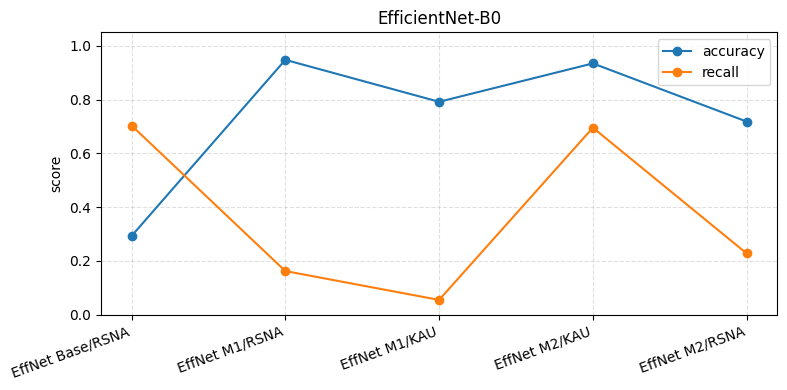

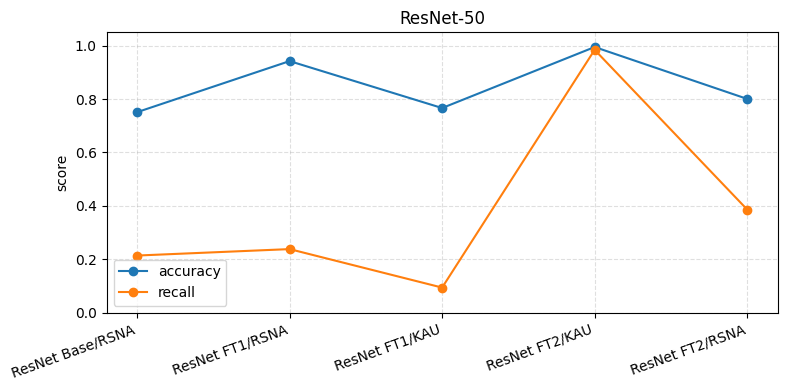

In [45]:
# 14.2 Line plots for EfficientNet-B0 and ResNet-50 (accuracy & recall)
def build_metric_series(pairs):
    """
    Helper function to build label, accuracy, and recall lists from 
    a list of (label, variable-name) tuples.
    Skips entries whose metric variable does not exist.
    """
    labels, acc, rec = [], [], []
    for label, var_name in pairs:
        if var_name in globals():
            m = globals()[var_name]
            labels.append(label)
            acc.append(m["accuracy"])
            rec.append(m["recall"])
    return labels, acc, rec

# -----------------------------
# EfficientNet-B0
# -----------------------------
eff_pairs = [
    ("EffNet Base/RSNA", "baseline_metrics"),   # Eff_Base on RSNA
    ("EffNet M1/RSNA",  "m1_test_metrics"),     # Eff_FT1 on RSNA
    ("EffNet M1/KAU",   "m1_kau_metrics"),      # Eff_FT1 on KAU (zero shot)
    ("EffNet M2/KAU",   "m2_kau_metrics"),      # Eff_FT2 on KAU
    ("EffNet M2/RSNA",  "m2_rsna_metrics"),     # Eff_FT2 on RSNA (back eval)
]

eff_labels, eff_acc, eff_rec = build_metric_series(eff_pairs)

plt.figure(figsize=(8, 4))
plt.plot(eff_labels, eff_acc, marker="o", linestyle="-", label="accuracy")
plt.plot(eff_labels, eff_rec, marker="o", linestyle="-", label="recall")
plt.title("EfficientNet-B0")
plt.ylabel("score")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# -----------------------------
# ResNet-50
# -----------------------------
res_pairs = [
    ("ResNet Base/RSNA",  "res_base_metrics"),   # Res_Base on RSNA
    ("ResNet FT1/RSNA",   "res_m1_test_metrics"),# Res_FT1 on RSNA
    ("ResNet FT1/KAU",    "res_m1_kau_metrics"), # Res_FT1 on KAU
    ("ResNet FT2/KAU",    "res_m2_kau_metrics"), # Res_FT2 on KAU
    ("ResNet FT2/RSNA",   "res_m2_rsna_metrics"),# Res_FT2 on RSNA
]

res_labels, res_acc, res_rec = build_metric_series(res_pairs)

plt.figure(figsize=(8, 4))
plt.plot(res_labels, res_acc, marker="o", linestyle="-", label="accuracy")
plt.plot(res_labels, res_rec, marker="o", linestyle="-", label="recall")
plt.title("ResNet-50")
plt.ylabel("score")
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


### 14.3 Interpretation of Results

EfficientNet-BO
EffNet Base scored a good recall, but simultaneously a bad accuracy. The high recall value implies that the model performed rather well when it comes to false negatives, meaning EffNet Base had a tendency to not qualify cancerous images as “no-cancer”. But, since the accuracy was very low, we can assume the model qualified most images as cancerous, which relativizes the high recall.
Feeding the model with RSNA data and fine-tuning it to EffNet M1 improved accuracy dramatically, but lowered recall too. This is most likely due to dataset problems. In oncology, tumors do not necessarily have to be malignant, they can be benign too. Since the ultimate goal for oncological radiology is to recognize malignant tumors from images, most available datasets categorize benign tumors as “no-cancer”, because they are not harmful. The RSNA dataset is one of these datasets, meaning there are images in the dataset classified as “no-cancer”, even though the patients have a tumor.
Recognizing the difference between a benign and a malignant tumor from an image is very hard to impossible. In practice, it can be necessary to extract tissue and analyze it to make sure what kind of tumor a patient has. Model EffNet M1 demonstrates this problem very well. Even though it scores a high accuracy, this is most likely due to the fact, that most of the images in the RSNA dataset (~98%) are classified as “no-cancer”, which means any model classifying most images as “no-cancer” will score high accuracy. The low recall value suggests that the model learned to classify tumorous images as “no-cancer”, because benign cancer is classified as such in the dataset, and the model was unable to tell the difference between benign and malignant tumors.
The good performance after fine-tuning with the KAU dataset (EffNet M2), which is structured differently (here we could define ourselves, that only non-tumorous images are to be classified as “no-cancer”) strengthens the theory from above. Now, all tumorous images are classified as “cancer”, leading to improvement in accuracy and strong improvement for recall. This suggests that the model is now good at telling the difference between tumorous and non-tumorous images.
Unfortunately, after re-evaluating model EffNet M2 with the RSNA dataset, we can see that the model’s accuracy on RSNA data declined. Still, recall improved compared to EffNet M1, meaning the model tends to forget, but it is no devastating loss in performance.
ResNet-50
The results for the ResNet-50 models are similar to the EfficientNet-B0 models. The only big difference stems from the base model. Here, the base model already has a similar, but slightly worse, performance than the first fine-tuned version. Accuracy is already high and recall low, suggesting the model classified most images as “no-cancer”. It seems The ResNet-50 base model differs here from the EfficientNet-B0 base model, by classifying most images in the same class too, but for the ResNet-50 base model this class was “no-cancer”, while for the EfficientNet-B0 base model it was “cancer”.
Worth mentioning is the spectacular good performance of model ResNet FT2, which was already fine-tuned on KAU data. This model not only scores almost perfect accuracy, but recall too, making it by far the best model of this project.